<a href="https://colab.research.google.com/github/vaidehi3112/Restaurant-Recommendation-System/blob/main/USML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
!pip install chart-studio
!pip install vaderSentiment
!pip install contractions
!pip install pyLDAvis
!pip install lime
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install folium
!pip install plotly_express
!pip install dask[dataframe]
!pip install datashader

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-8zd4ooz5
  Running command git clone -q git://git

In [ ]:
import numpy as np
import pandas as pd


#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import dask.dataframe as dd
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire, kbc, bmw, gray
import plotly.express as px
import matplotlib.colors as mcolors

import folium

#Sentiment Analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import os

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

#text preprocessing
import re, string, unicodedata
import nltk
import inflect
import contractions
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#Topic Modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from pprint import pprint
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Preprocessing

###Business File

In [ ]:
business = pd.read_json ('/content/drive/MyDrive/USML_Project/yelp_academic_dataset_business.json', lines=True)

In [ ]:
business.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [ ]:
#Filter the businesses which are open
business = business[business['is_open']==1]

In [ ]:
# Drop columns that aren't needed
drop_columns = ['hours','is_open', 'address', 'attributes']
business = business.drop(drop_columns, axis=1)

In [ ]:
business_explode = business.assign(categories = business.categories
                         .str.split(', ')).explode('categories')

In [ ]:
#unique categories with their counts
business_explode.categories.value_counts()

Restaurants               34987
Food                      20419
Shopping                  20186
Home Services             13322
Beauty & Spas             12263
                          ...  
Guamanian                     1
Cheese Tasting Classes        1
Bike Repair                   1
Tonkatsu                      1
Trade Fairs                   1
Name: categories, Length: 1302, dtype: int64

In [ ]:
#Filter restaurant category
business = business[business['categories'].str.contains(
             'Restaurants',
              case=False, na=False)]
business.shape

(34987, 10)

In [ ]:
business = business[business['city'] == 'Philadelphia']
business.shape

(3525, 10)

In [ ]:
business.to_csv ('/content/drive/MyDrive/USML_Project/business_philadelphia.csv', index = None)

###Review File

In [ ]:
for num in range(1,10):
    exec(f'subrev_df{num} = pd.read_json(path_or_buf="/content/drive/MyDrive/USML_Project/yelp_reviews_sub{num}.json", lines=True)')

In [ ]:
subrev_df_dict = {'subrev_df1':subrev_df1, 'subrev_df2':subrev_df2, 'subrev_df3':subrev_df3, \
                  'subrev_df4':subrev_df4, 'subrev_df5':subrev_df5, 'subrev_df6':subrev_df6, \
                  'subrev_df7':subrev_df7, 'subrev_df8':subrev_df8, 'subrev_df9':subrev_df9}

rest_subrev_df_list = []

for key, val in subrev_df_dict.items():
  #inner merge/join, so the reviews will be unique to its respective business; no duplicates of a review instance
    exec(f'rest_{key} = {key}.merge(business, on="business_id", suffixes=("_user", "_yelp"))')
    exec(f'rest_subrev_df_list.append(rest_{key})')
  # exec(f'rest_subrev_df_list.append({key})')

# the final dataset made via concaetantion
reviews = pd.concat(rest_subrev_df_list)

In [ ]:
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                date  \
0  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ... 2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak... 2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac... 2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a... 2015-07-28 17:15:20   

    name          city state postal_code   latitude  longitude  stars_yelp  \
0  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
1  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
2  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
3  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
4  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   

   review_count                             categories  
0           181  Halal, Pakistani, Restaurants, Indian  
1           181  Halal, Pakistani, Restaurants, Indian  
2           181  Halal, Pakistani, Restaurants, Indian  
3           181  Halal, Pakistani, Restaurants, Indian  
4           181  Halal, Pakistani, Restaurants, Indian

In [ ]:
reviews.date = pd.to_datetime(reviews.date)
reviews['year'] = reviews.date.dt.year
reviews['month'] = reviews.date.dt.month

In [ ]:
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                date  \
0  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ... 2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak... 2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac... 2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a... 2015-07-28 17:15:20   

    name          city state postal_code   latitude  longitude  stars_yelp  \
0  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
1  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
2  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
3  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   
4  Zaika  Philadelphia    PA       19114  40.079848  -75.02508         4.0   

   review_count                             categories  year  month  
0           181  Halal, Pakistani, Restaurants, Indian  2015      1  
1           181  Halal, Pakistani, Restaurants, Indian  2014      7  
2           181  Halal, Pakistani, Restaurants, Indian  2010      8  
3           181  Halal, Pakistani, Restaurants, Indian  2017      1  
4           181  Halal, Pakistani, Restaurants, Indian  2015      7

In [ ]:
reviews.to_csv ('/content/drive/MyDrive/USML_Project/reviews_final.csv', index = None)

# EDA

In [ ]:
Restaurant = pd.read_csv('/content/drive/MyDrive/USML_Project/reviews_final.csv')

In [ ]:
Restaurant.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                 date  \
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ...  2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak...  2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac...  2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a...  2015-07-28 17:15:20   

    name          city state  postal_code   latitude  longitude  stars_yelp  \
0  Zaika  Philadelphia    PA        19114  40.079848  -75.02508         4.0   
1  Zaika  Philadelphia    PA        19114  40.079848  -75.02508         4.0   
2  Zaika  Philadelphia    PA        19114  40.079848  -75.02508         4.0   
3  Zaika  Philadelphia    PA        19114  40.079848  -75.02508         4.0   
4  Zaika  Philadelphia    PA        19114  40.079848  -75.02508         4.0   

   review_count                             categories  year  month  
0           181  Halal, Pakistani, Restaurants, Indian  2015      1  
1           181  Halal, Pakistani, Restaurants, Indian  2014      7  
2           181  Halal, Pakistani, Restaurants, Indian  2010      8  
3           181  Halal, Pakistani, Restaurants, Indian  2017      1  
4           181  Halal, Pakistani, Restaurants, Indian  2015      7

In [ ]:
x=Restaurant['stars_user'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of Restaurant Ratings in Philadelphia")
plt.ylabel('count')
plt.xlabel('Stars/Ratings')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

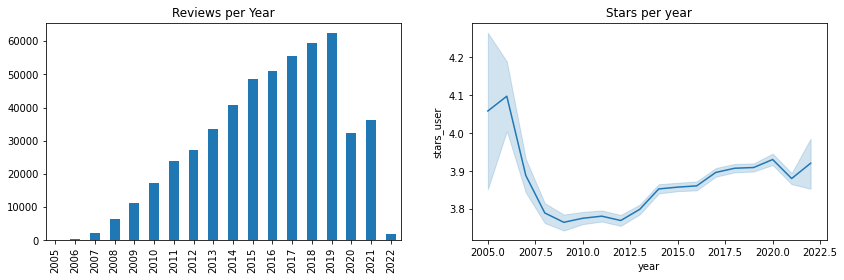

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
Restaurant.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0]);
sns.lineplot(x='year', y='stars_user', data=Restaurant, ax=axes[1])
axes[1].set_title('Stars per year');

In [ ]:
positive = Restaurant[Restaurant['stars_yelp'] >= 3]
negative = Restaurant[Restaurant['stars_yelp'] < 3]

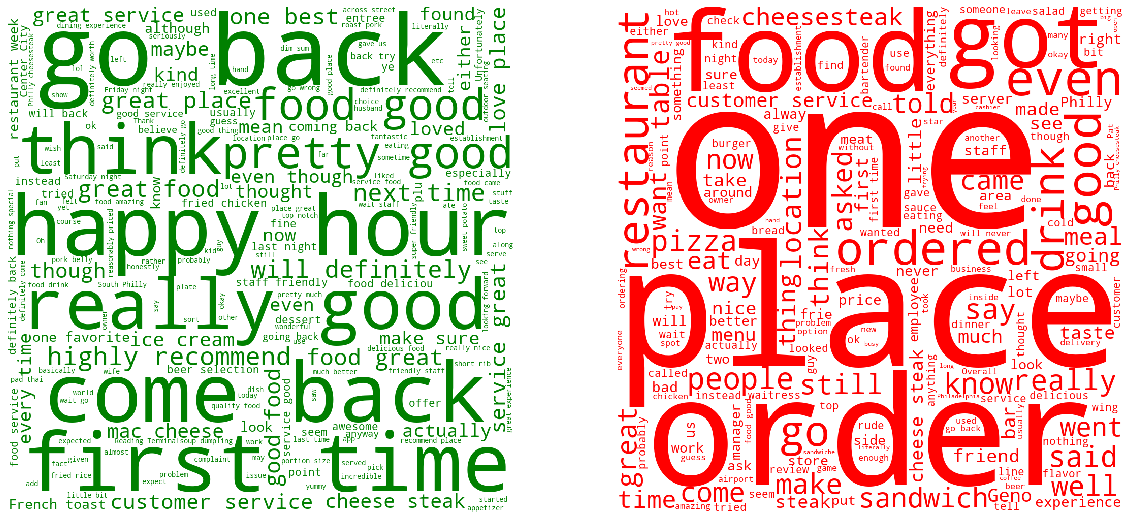

In [ ]:
# gather all words together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,20))

pos_text = ""
pos_snippets = positive["text"].values

for snippet in pos_snippets:
    pos_text += snippet

# plot Wordcloud
wordcloud_pos = WordCloud(stopwords=STOPWORDS, background_color='white', height = 1000, width = 1000, color_func=lambda *args, **kwargs: "green").generate(pos_text)
ax1.imshow(wordcloud_pos, interpolation = "None")
ax1.axis("off")

neg_text = ""
neg_snippets = negative["text"].values

for snippet in neg_snippets:
    neg_text += snippet

# plot Wordcloud
wordcloud_neg = WordCloud(stopwords=STOPWORDS, background_color='white', height = 1000, width = 1000, color_func=lambda *args, **kwargs: "red").generate(neg_text)
ax2.imshow(wordcloud_neg, interpolation = "None")
ax2.axis("off")
# fig.suptitle('Word Clouds of Positive (Left) and Negative (Right) Reviews')
plt.show()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/USML_Project/business_philadelphia.csv', on_bad_lines='skip')

In [ ]:
data = data[['city', 'name', 'review_count','stars', 'latitude', 'longitude']]
# data = data[data['city'] == 'Philadelphia']
data.dropna(subset = ['latitude', 'longitude'], inplace = True)

In [ ]:
cvs = ds.Canvas(plot_width=4000, plot_height=4000)
agg = cvs.points(data, x='longitude', y='latitude')
# agg is an xarray object
coords_lat, coords_lon = agg.coords['latitude'].values, agg.coords['longitude'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [ ]:
img=(tf.shade(agg, cmap = fire, how='eq_hist', alpha = 100))[::-1].to_pil() #pil stands for Python Image Library


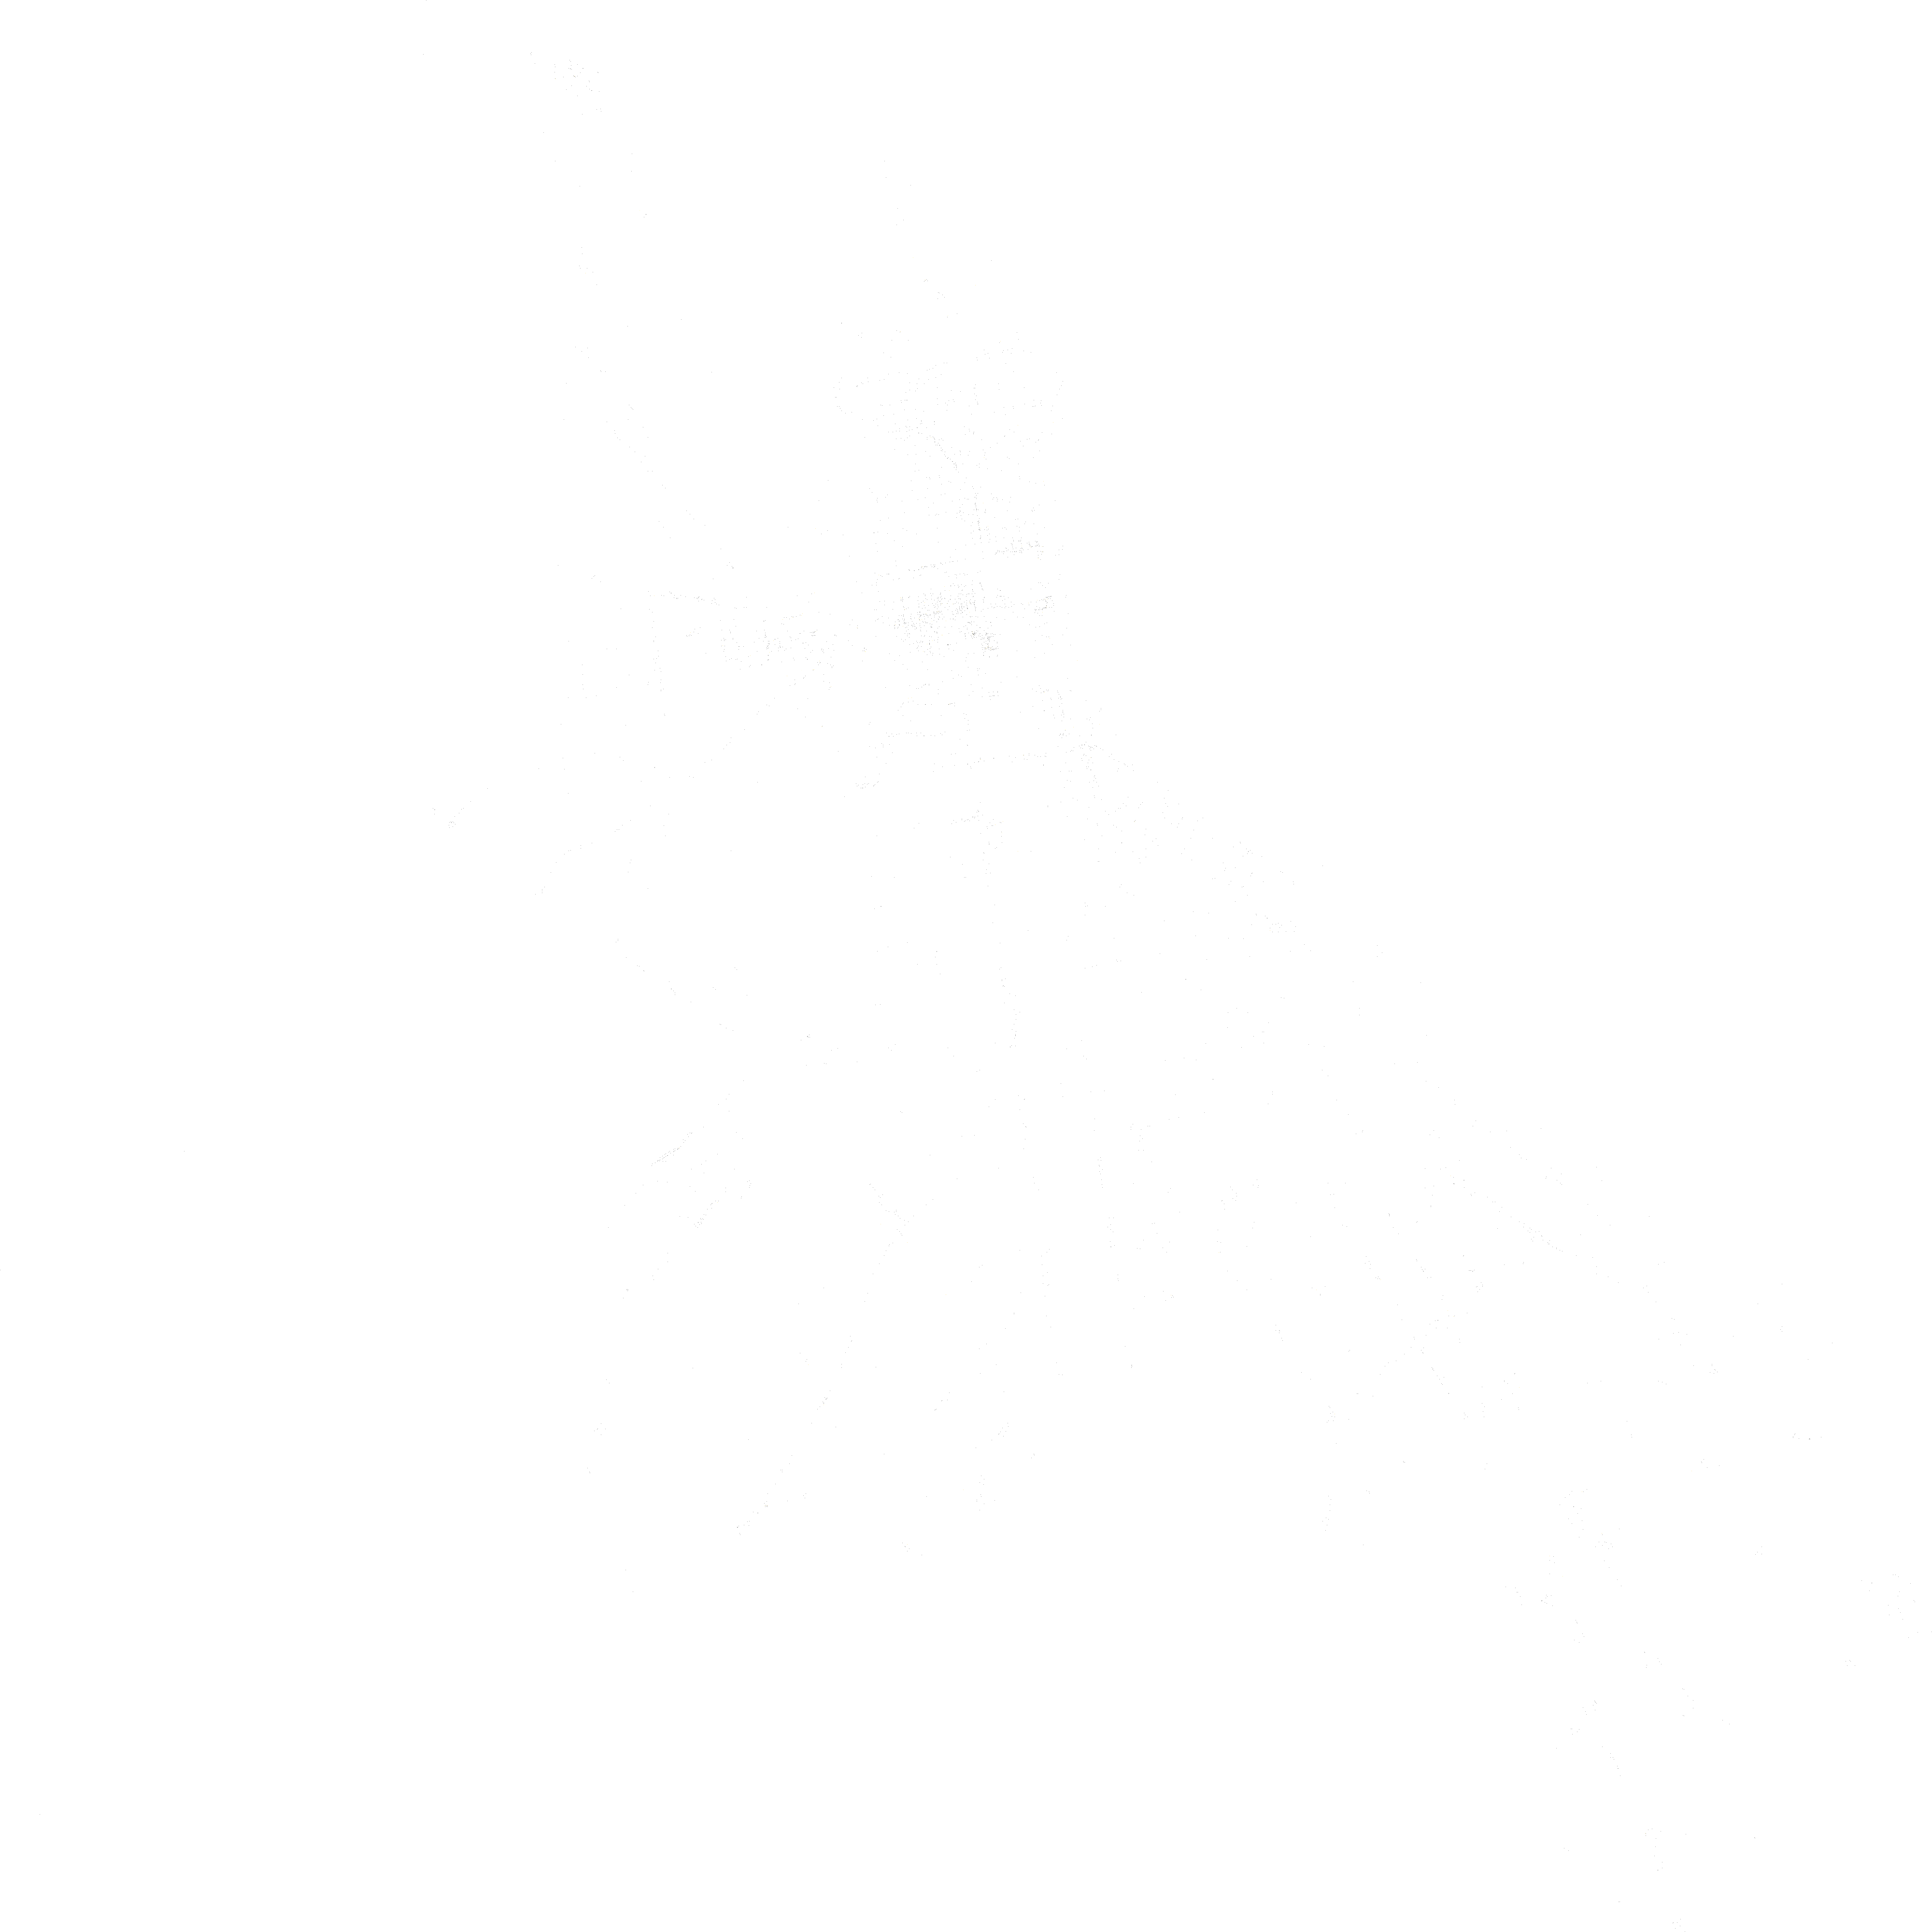

In [ ]:
fig = px.scatter_mapbox(data, lat= "latitude", lon="longitude", hover_name = "name", hover_data = ["name", "stars"], zoom=10, color="stars", size = "review_count", width=1000, height=700, size_max=15)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

# Sentiment Analysis

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/USML_Project/reviews_final.csv', on_bad_lines='skip')

In [ ]:
reviews = reviews[reviews.notnull()]

### Text Cleaning

In [ ]:
# Import Textblob

from textblob import Word

# Splitting up words in reviews

reviews['cleaned_text'] = reviews['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation

reviews['cleaned_text'] = reviews['cleaned_text'].str.replace('[^\w\s]', '')

# Remove Stopwords

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
reviews['cleaned_text'] = reviews['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

# Lemmatizing cleaned text

reviews['cleaned_text'] = reviews['cleaned_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                 date  \
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ...  2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak...  2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac...  2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a...  2015-07-28 17:15:20   

    name  ... state postal_code   latitude  longitude  stars_yelp  \
0  Zaika  ...    PA       19114  40.079848  -75.02508         4.0   
1  Zaika  ...    PA       19114  40.079848  -75.02508         4.0   
2  Zaika  ...    PA       19114  40.079848  -75.02508         4.0   
3  Zaika  ...    PA       19114  40.079848  -75.02508         4.0   
4  Zaika  ...    PA       19114  40.079848  -75.02508         4.0   

   review_count                             categories  year  month  \
0           181  Halal, Pakistani, Restaurants, Indian  2015      1   
1           181  Halal, Pakistani, Restaurants, Indian  2014      7   
2           181  Halal, Pakistani, Restaurants, Indian  2010      8   
3           181  Halal, Pakistani, Restaurants, Indian  2017      1   
4           181  Halal, Pakistani, Restaurants, Indian  2015      7   

                                        cleaned_text  
0  wow yummy different delicious favorite lamb cu...  
1  dinein get 2 star disappointing service venue ...  
2  long hiatus reviewing awaken 6 mouth yelp hibe...  
3  weve eaten 3 time seems time get even better s...  
4  came philly family event stayed little dinner ...  

[5 rows x 21 columns]

In [ ]:
reviews.to_csv('/content/drive/MyDrive/USML_Project/text_cleaned.csv', index = False)

### Textblob Polarity and Subjectivity Scores

In [ ]:
# Calculate polarity and subjectivity score

from textblob import TextBlob

reviews['polarity'] = reviews['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[0])
reviews['subjectivity'] = reviews['cleaned_text'].apply(lambda x: TextBlob(x).sentiment[1])
reviews.head(3)

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   

                                                text                 date  \
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ...  2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak...  2010-08-20 19:16:04   

    name  ...   latitude longitude  stars_yelp  review_count  \
0  Zaika  ...  40.079848 -75.02508         4.0           181   
1  Zaika  ...  40.079848 -75.02508         4.0           181   
2  Zaika  ...  40.079848 -75.02508         4.0           181   

                              categories  year  month  \
0  Halal, Pakistani, Restaurants, Indian  2015      1   
1  Halal, Pakistani, Restaurants, Indian  2014      7   
2  Halal, Pakistani, Restaurants, Indian  2010      8   

                                        cleaned_text  polarity  subjectivity  
0  wow yummy different delicious favorite lamb cu...  0.315152      0.733838  
1  dinein get 2 star disappointing service venue ...  0.037143      0.471429  
2  long hiatus reviewing awaken 6 mouth yelp hibe...  0.131955      0.524916  

[3 rows x 23 columns]

### Vader Sentiment Scores

In [ ]:
# Calculate Vader Sentiment Analysis Scores

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentiment = reviews['text'].apply(lambda x: analyzer.polarity_scores(x))
reviews = pd.concat([reviews,sentiment.apply(pd.Series)],1)
reviews.sample(5)

review_id                 user_id  \
504024  73mu7fbamb38KFFpiTO5kQ  7ifdrplzL1QZnlJppjZEjw   
298775  Ka_XmetIebF6EeLPu7labw  SMmfQVL-1qCMAh3oXMHz_g   
394527  pqeBbvITu21PRdfkU9OvKA  ub1AgBJRK71EZU14f4AaBQ   
227365  qIn2S6kBxVRiaykRqeKtnA  4xudantfMxLy1l5G1tWGnw   
283654  r6Xj4s_yjqNWtk-WQQnDRA  2LfozZiejXfQHcS52-Fv5w   

                   business_id  stars_user  useful  funny  cool  \
504024  sDaBm5V1VQMOPfCm76turg           5       1      5     1   
298775  mLdqrqgEXuUrCdgHLr30QQ           5       0      0     0   
394527  6_LnAQQ0-mml8YgpfRjGuA           5       2      0     1   
227365  YaLKDgS_zIYIm6jkXWCxgA           5       0      0     0   
283654  swcfmflnWlhnbvPOHvPq_A           4       1      0     1   

                                                     text  \
504024  Applebee's food... 0 stars. (Mo?), The Bartend...   
298775  Great desserts. Came with the whole family and...   
394527  Of all the scrumptious halal joints in the wor...   
227365        Best pizza in the City or surrounding area.   
283654  The fresh spring rolls were delicious , my tof...   

                       date                     name  ...  \
504024  2010-10-20 02:10:52   Applebee's Grill + Bar  ...   
298775  2018-08-25 19:56:50      Mango Mango Dessert  ...   
394527  2014-02-13 11:07:11  Saad's Halal Restaurant  ...   
227365  2009-05-07 16:27:13                  Rustica  ...   
283654  2010-02-22 15:13:55       Chabaa Thai Bistro  ...   

                                               categories  year  month  \
504024  American (Traditional), Bars, Nightlife, Ameri...  2010     10   
298775   Food, Desserts, Shaved Ice, Waffles, Restaurants  2018      8   
394527  Halal, Middle Eastern, Restaurants, Food, Indi...  2014      2   
227365            Restaurants, Italian, Sandwiches, Pizza  2009      5   
283654                         Restaurants, Thai, Noodles  2010      2   

                                             cleaned_text  polarity  \
504024  applebees food 0 star mo bartender served u ke...  0.000000   
298775  great dessert came whole family ordered three ...  0.360000   
394527  scrumptious halal joint world may one best 2 w...  0.400000   
227365                   best pizza city surrounding area  1.000000   
283654  fresh spring roll delicious tofu basil fried r...  0.283333   

        subjectivity    neg    neu    pos  compound  
504024      0.000000  0.000  1.000  0.000    0.0000  
298775      0.581667  0.000  0.630  0.370    0.9459  
394527      0.750000  0.000  0.705  0.295    0.9060  
227365      0.300000  0.000  0.625  0.375    0.6369  
283654      0.625000  0.019  0.816  0.165    0.9662  

[5 rows x 27 columns]

### Classify the Reviews into Positive, Negative and Neutral

In [ ]:
# create a list of our conditions
conditions = [
    (reviews['stars_user'] <= 2.0),
    (reviews['stars_user'] == 3.0),
    (reviews['stars_user'] >= 4.0)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'neutral', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
reviews['sentiment'] = np.select(conditions, values)

# display updated DataFrame
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                 date  \
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ...  2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak...  2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac...  2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a...  2015-07-28 17:15:20   

    name  ...  year month                                       cleaned_text  \
0  Zaika  ...  2015     1  wow yummy different delicious favorite lamb cu...   
1  Zaika  ...  2014     7  dinein get 2 star disappointing service venue ...   
2  Zaika  ...  2010     8  long hiatus reviewing awaken 6 mouth yelp hibe...   
3  Zaika  ...  2017     1  weve eaten 3 time seems time get even better s...   
4  Zaika  ...  2015     7  came philly family event stayed little dinner ...   

   polarity  subjectivity    neg    neu    pos  compound  sentiment  
0  0.315152      0.733838  0.000  0.660  0.340    0.9588   positive  
1  0.037143      0.471429  0.100  0.900  0.000   -0.6505   negative  
2  0.131955      0.524916  0.055  0.807  0.138    0.9972   positive  
3  0.319792      0.592708  0.022  0.772  0.206    0.9339   positive  
4  0.178125      0.862500  0.000  0.730  0.270    0.8918   positive  

[5 rows x 28 columns]

In [ ]:
dropped_reviews = reviews[(reviews.polarity ==0.0) & (reviews.compound==0.0) & (reviews.subjectivity==0.0)]
print(dropped_reviews.shape)
dropped_reviews.sample(5)

(857, 28)


review_id                 user_id  \
14621   OEhvLOH4ZI6vWnwX_P1GIQ  Ywok1ET26628qFeFA9mnuw   
118809  d1ZAyls7Rkk1yJF11HnTyg  vsUEVeLb1dcMc2KwO_h5lw   
389324  9ovVRWccj1V7QACHtupVPA  Cu8v6y9zQgKWkiu5nkoR4A   
146371  JYa6XYFLter_uoEBm29YwQ  AC6RJu4T4yUNgcEHrkLNGg   
264055  q_YGDYYakh1qrYtfo-prog  HqEJp199P9Uriiab7o4-1g   

                   business_id  stars_user  useful  funny  cool  \
14621   JUlsvVAvZvGHWFfkKm0nlg           5       0      0     0   
118809  -cEFKAznWmI0cledNOIQ7w           5       1      1     1   
389324  IWHdx0NhDKADkGOgXgOFKQ           5       0      0     0   
146371  PsyoQwBcxs98DP-2tBOv6A           4       0      0     0   
264055  2m8Gdh2AYepXn0dQBA5y8Q           2       0      0     0   

                                                     text  \
14621   half-price margarita pitchers on tuesday. i'm ...   
118809  Posto eccellente così come il cibo, oggi ho pr...   
389324  order roast pork with provolone and broccoli rabe   
146371  My rating is on drinks selection and service. ...   
264055  They never make sizzles. Other then mornings e...   

                       date                            name  ...  year month  \
14621   2012-06-26 16:14:58                  El Camino Real  ...  2012     6   
118809  2016-03-10 03:25:57             Gran Caffe L'Aquila  ...  2016     3   
389324  2012-04-16 07:54:59                   Tommy DiNic's  ...  2012     4   
146371  2015-10-31 02:53:56  Mad Greek Restaurant and Pizza  ...  2015    10   
264055  2019-10-22 10:31:53                            Wawa  ...  2019    10   

                                             cleaned_text  polarity  \
14621   halfprice margarita pitcher tuesday im mahi ma...       0.0   
118809  posto eccellente così come il cibo oggi ho pre...       0.0   
389324           order roast pork provolone broccoli rabe       0.0   
146371  rating drink selection service place go youre ...       0.0   
264055  never make sizzle morning everytime order sand...       0.0   

        subjectivity  neg  neu  pos  compound  sentiment  
14621            0.0  0.0  1.0  0.0       0.0   positive  
118809           0.0  0.0  1.0  0.0       0.0   positive  
389324           0.0  0.0  1.0  0.0       0.0   positive  
146371           0.0  0.0  1.0  0.0       0.0   positive  
264055           0.0  0.0  1.0  0.0       0.0   negative  

[5 rows x 28 columns]

In [ ]:
# Dropping these filtered rows

reviews = reviews.drop(index = dropped_reviews.index)
print(reviews.shape)
reviews.sample(3)

(510281, 28)


review_id                 user_id  \
127987  FCvbHc_TU9vqzqJUhrHYCw  77_lii-OH7OLUU9ZVwps5w   
250085  3IwUMCTqoHi4gcKKDMDpCg  FlXBpK_YZxLo27jcMdII1w   
214736  bGz2LPCBvlmc78QNtTBe3w  lx_SRBmAzcG58TBgP2nbMA   

                   business_id  stars_user  useful  funny  cool  \
127987  uD_nMWd5b5d7gW1srYH6Jg           5       3      2     1   
250085  KPyHQaKR7G0tuVedn4y9Dw           4       2      0     1   
214736  Zwyimxd54QZ_2cykFDJ_VA           1       3      0     0   

                                                     text  \
127987  I ordered oxtails and man oh man was they good...   
250085  Great for some things, not so much for others....   
214736  I have patronized this location on two occasio...   

                       date                           name  ...  year month  \
127987  2014-04-02 13:24:19                      Top Taste  ...  2014     4   
250085  2013-05-30 04:01:16                New Pizza Villa  ...  2013     5   
214736  2018-07-27 01:40:24  Passyunk Avenue Philly Bagels  ...  2018     7   

                                             cleaned_text  polarity  \
127987  ordered oxtail man oh man good gravy rice pea ...  0.600000   
250085  great thing much others favorite thing order b...  0.334583   
214736  patronized location two occasion first first o... -0.058144   

        subjectivity    neg    neu    pos  compound  sentiment  
127987      0.525000  0.039  0.751  0.209    0.9372   positive  
250085      0.561859  0.015  0.682  0.303    0.9823   positive  
214736      0.221117  0.049  0.951  0.000   -0.8930   negative  

[3 rows x 28 columns]

In [ ]:
reviews.to_csv('/content/drive/MyDrive/USML_Project/sentiment_reviews.csv', index = False)

# Topic Modeling

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/USML_Project/sentiment_reviews.csv')

In [ ]:
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user  useful  funny  cool  \
0           5       1      0     1   
1           2       0      0     1   
2           5      13      6     5   
3           5       1      1     1   
4           5       0      0     0   

                                                text                 date  \
0  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03   
1  Dine-in gets 2 stars. Disappointing service & ...  2014-07-13 17:25:47   
2  After a long hiatus from reviewing I have awak...  2010-08-20 19:16:04   
3  We've eaten here 3 times and it seems that eac...  2017-01-02 14:25:26   
4  Came to Philly for a family event but stayed a...  2015-07-28 17:15:20   

    name  ...  year month                                       cleaned_text  \
0  Zaika  ...  2015     1  wow yummy different delicious favorite lamb cu...   
1  Zaika  ...  2014     7  dinein get 2 star disappointing service venue ...   
2  Zaika  ...  2010     8  long hiatus reviewing awaken 6 mouth yelp hibe...   
3  Zaika  ...  2017     1  weve eaten 3 time seems time get even better s...   
4  Zaika  ...  2015     7  came philly family event stayed little dinner ...   

   polarity  subjectivity    neg    neu    pos  compound  sentiment  
0  0.315152      0.733838  0.000  0.660  0.340    0.9588   positive  
1  0.037143      0.471429  0.100  0.900  0.000   -0.6505   negative  
2  0.131955      0.524916  0.055  0.807  0.138    0.9972   positive  
3  0.319792      0.592708  0.022  0.772  0.206    0.9339   positive  
4  0.178125      0.862500  0.000  0.730  0.270    0.8918   positive  

[5 rows x 28 columns]

### Drop Unnecessary Columns

In [ ]:
reviews.drop(columns =['useful', 'funny', 'cool'], axis = 1, inplace=True)

In [ ]:
reviews.head()

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user                                               text  \
0           5  Wow!  Yummy, different,  delicious.   Our favo...   
1           2  Dine-in gets 2 stars. Disappointing service & ...   
2           5  After a long hiatus from reviewing I have awak...   
3           5  We've eaten here 3 times and it seems that eac...   
4           5  Came to Philly for a family event but stayed a...   

                  date   name          city state  postal_code  ...  year  \
0  2015-01-04 00:01:03  Zaika  Philadelphia    PA        19114  ...  2015   
1  2014-07-13 17:25:47  Zaika  Philadelphia    PA        19114  ...  2014   
2  2010-08-20 19:16:04  Zaika  Philadelphia    PA        19114  ...  2010   
3  2017-01-02 14:25:26  Zaika  Philadelphia    PA        19114  ...  2017   
4  2015-07-28 17:15:20  Zaika  Philadelphia    PA        19114  ...  2015   

   month                                       cleaned_text  polarity  \
0      1  wow yummy different delicious favorite lamb cu...  0.315152   
1      7  dinein get 2 star disappointing service venue ...  0.037143   
2      8  long hiatus reviewing awaken 6 mouth yelp hibe...  0.131955   
3      1  weve eaten 3 time seems time get even better s...  0.319792   
4      7  came philly family event stayed little dinner ...  0.178125   

  subjectivity    neg    neu    pos  compound  sentiment  
0     0.733838  0.000  0.660  0.340    0.9588   positive  
1     0.471429  0.100  0.900  0.000   -0.6505   negative  
2     0.524916  0.055  0.807  0.138    0.9972   positive  
3     0.592708  0.022  0.772  0.206    0.9339   positive  
4     0.862500  0.000  0.730  0.270    0.8918   positive  

[5 rows x 25 columns]

In [ ]:
reviews_final = pd.read_csv('/content/drive/MyDrive/USML_Project/reviews_final.csv')

### Text Preprocessing

In [ ]:
# Converting words in reviews to a list

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list

data = reviews.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['wow', 'yummy', 'different', 'delicious', 'our', 'favorite', 'is', 'the', 'lamb', 'curry', 'and', 'korma', 'with', 'different', 'kinds', 'of', 'naan', 'dont', 'let', 'the', 'outside', 'deter', 'you', 'because', 'we', 'almost', 'changed', 'our', 'minds', 'go', 'in', 'and', 'try', 'something', 'new', 'youll', 'be', 'glad', 'you', 'did']]


In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
# Text Processing
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

import spacy

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### LDA Model

In [ ]:
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.051*"order" + 0.035*"food" + 0.018*"ask" + 0.018*"give" + 0.018*"time" + '
  '0.015*"tell" + 0.015*"service" + 0.015*"minute" + 0.012*"pizza" + '
  '0.012*"customer"'),
 (1,
  '0.033*"wait" + 0.025*"time" + 0.023*"place" + 0.020*"friend" + 0.019*"open" '
  '+ 0.016*"bad" + 0.014*"next" + 0.014*"eat" + 0.013*"long" + 0.012*"day"'),
 (2,
  '0.033*"restaurant" + 0.021*"drink" + 0.019*"menu" + 0.015*"bar" + '
  '0.015*"dinner" + 0.013*"table" + 0.011*"experience" + 0.011*"really" + '
  '0.010*"night" + 0.010*"little"'),
 (3,
  '0.058*"great" + 0.055*"food" + 0.042*"place" + 0.037*"pizza" + 0.029*"love" '
  '+ 0.025*"amazing" + 0.024*"service" + 0.022*"definitely" + '
  '0.020*"recommend" + 0.020*"back"'),
 (4,
  '0.025*"order" + 0.019*"chicken" + 0.017*"sauce" + 0.016*"taste" + '
  '0.015*"fry" + 0.013*"flavor" + 0.012*"fresh" + 0.012*"cheese" + '
  '0.010*"steak" + 0.009*"really"')]


In [ ]:
lda_model.save('/content/drive/MyDrive/USML_Project/lda_model_final.model')

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel.load('/content/drive/MyDrive/USML_Project/lda_model_final.model')

In [13]:
corpus = [lda_model.id2word.doc2bow(text) for text in data_ready]

In [14]:
import seaborn as sns
import matplotlib.colors as mcolors

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

### Plot t-SNE on LDA Topics

In [ ]:
from bokeh.models import ColumnDataSource

In [ ]:
import plotly.express as px

In [ ]:
tsne_df = pd.DataFrame(tsne_lda)

In [ ]:
tsne_topics = pd.DataFrame(topic_num)

In [ ]:
tsne_topics.columns=['topics']

In [ ]:
tsne_final = pd.concat([tsne_df, tsne_topics], axis=1)

In [ ]:
tsne_final.to_csv('/content/drive/MyDrive/USML_Project/tsne_final_data.csv', index=False)

In [ ]:
tsne_final_df = pd.read_csv('/content/drive/MyDrive/USML_Project/tsne_final_data.csv')

In [ ]:
import plotly.express as px

In [ ]:
tsne_final_df1 = tsne_final_df.iloc[:40000]

In [ ]:
tsne_final_df1['topics'] = tsne_final_df1['topics'].apply(str)

In [ ]:
tsne_final_df1.columns = ['0', '1', 'Topic']

In [ ]:
tsne_final_df1.shape

(40000, 3)

In [ ]:
fig = px.scatter(
    tsne_final_df1, x='0', y='1', width=900, height=700,
    title = "t-SNE Clustering of 5 LDA Topics",
    labels={
                     "0": "tsne-2d-one",
                     "1": "tsne-2d-two",
                      'color': 'Topic'
                 },
    color=tsne_final_df1.Topic
)

In [ ]:
fig.update_layout(title_text='t-SNE Clustering of 5 LDA Topics', title_x=0.5, title_y = 0.9)

### Plot UMAP on LDA Topics

In [15]:
pip install umap-learn

In [16]:
import umap

In [17]:
from umap import UMAP

In [19]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
umap_lda = umap_2d.fit_transform(arr)

In [20]:
umap_df = pd.DataFrame(umap_lda)

In [21]:
umap_topics = pd.DataFrame(topic_num)

In [22]:
umap_topics.columns=['topics']

In [23]:
umap_final = pd.concat([umap_df, umap_topics], axis=1)

In [24]:
umap_final.to_csv('/content/drive/MyDrive/USML_Project/umap_final_data.csv', index=False)

In [25]:
umap_final_df = pd.read_csv('/content/drive/MyDrive/USML_Project/umap_final_data.csv')

In [26]:
umap_final_df1 = umap_final_df.iloc[:40000]

In [27]:
umap_final_df1['topics'] = umap_final_df1['topics'].apply(str)

In [28]:
umap_final_df1.columns = ['0', '1', 'Topic']

In [29]:
fig1 = px.scatter(
    umap_final_df1, x='0', y='1', width=900, height=700,
    title = "U-MAP Clustering of 5 LDA Topics",
    labels={
                     "0": "umap-2d-one",
                     "1": "umap-2d-two",
                      'color': 'Topic'
                 },
    color=umap_final_df1.Topic
)

In [30]:
fig1.update_layout(title_x=0.5, title_y = 0.9)

### Word Cloud of 5 LDA Topics

IndexError: ignored

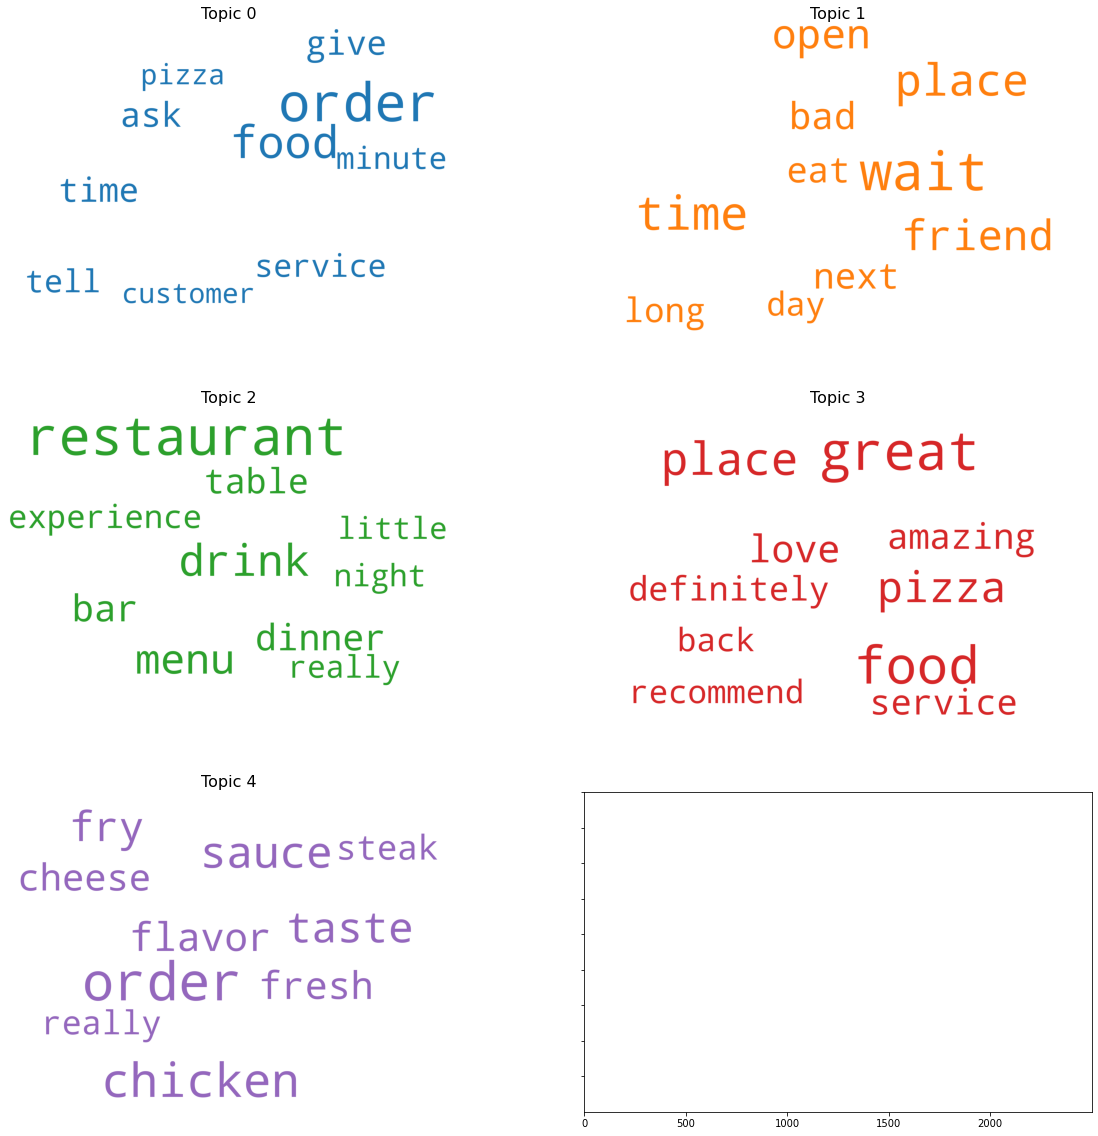

In [ ]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOP_WORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = new_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('/content/drive/MyDrive/USML_Project/topic_modeling_wordcloud.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
# 5 topics

# import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(new_model, corpus, dictionary=new_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.205820 -0.010740       1        1  27.496810
2      0.257175 -0.050336       2        1  21.167952
3     -0.168141 -0.159285       3        1  18.088906
0     -0.188495 -0.143794       4        1  17.232881
1     -0.106359  0.364154       5        1  16.013451, topic_info=           Term           Freq          Total Category  logprob  loglift
248       great  202649.000000  202649.000000  Default  30.0000  30.0000
16        order  303676.000000  303676.000000  Default  29.0000  29.0000
12         food  348837.000000  348837.000000  Default  28.0000  28.0000
304  restaurant  135823.000000  135823.000000  Default  27.0000  27.0000
800       pizza  168763.000000  168763.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
361       night   24651.868339   67255.055764   Topic5  -4.8307   0.8281
575      people   21964.312598   58443.269518   Topic5  -4.9461   0.8531
63        drink   24047.764348  111351.199771   Topic5  -4.8555   0.2991
133        much   19533.655567   63531.744094   Topic5  -5.0634   0.6523
456       visit   18928.035559   36049.572166   Topic5  -5.0949   1.1875

[263 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
217       3  0.999975     always
381       3  0.999990    amazing
29        2  0.999974  appetizer
821       4  0.999978     arrive
537       4  0.999989        ask
...     ...       ...        ...
379       2  0.999935       wish
229       3  0.999970  wonderful
260       1  0.358035      worth
260       3  0.641946      worth
380       5  0.999960       year

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

In [ ]:
pyLDAvis.save_html(vis, '/content/drive/MyDrive/USML_Project/lda.html')

### Get Dominant Topic Number for each Review and Keywords

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=new_model, corpus=corpus, texts=data_ready)

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  \
0            0             0.0   
1            1             4.0   
2            2             4.0   
3            3             1.0   
4            4             3.0   
5            5             3.0   
6            6             4.0   
7            7             0.0   
8            8             2.0   
9            9             1.0   

                                            Keywords  \
0  order, food, ask, give, time, tell, service, m...   
1  order, chicken, sauce, taste, fry, flavor, fre...   
2  order, chicken, sauce, taste, fry, flavor, fre...   
3  wait, time, place, friend, open, bad, next, ea...   
4  great, food, place, pizza, love, amazing, serv...   
5  great, food, place, pizza, love, amazing, serv...   
6  order, chicken, sauce, taste, fry, flavor, fre...   
7  order, food, ask, give, time, tell, service, m...   
8  restaurant, drink, menu, bar, dinner, table, e...   
9  wait, time, place, friend, open, bad, next, ea...   

                                                Text  
0  [different, favorite, different, kind, let, ou...  
1  [star, disappoint, service, venue, fall, short...  
2  [long, review, awaken, mouth, hibernation, tum...  
3  [eat, time, time, well, last, time, spiritual,...  
4  [philly, family, event, stay, little, dinner, ...  
5  [neat, little, hole, wall, clean, extremely, f...  
6  [place, great, find, interior, food, really, s...  
7  [several, time, price, reasonable, food, quite...  
8  [find, place, yelp, review, look, great, india...  
9  [love, love, owner, lady, wait, lovely, warm, ...

In [ ]:
# Append new columns onto reviews dataset

df_dominant_topic['Text_Chunks'] = df_dominant_topic['Text']
extra_feature_columns = df_dominant_topic[['Dominant_Topic', 'Keywords', 'Text_Chunks']]
final_reviews = pd.concat([reviews,extra_feature_columns], axis=1).reindex(reviews.index)
final_reviews.head(10)

review_id                 user_id             business_id  \
0  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
1  HME_ksGph3se7Aze5hxa-Q  kSMOJwJXuEUqzfmuFncK4A  kxX2SOes4o-D3ZQBkiMRfA   
2  EJWyA5wpdVMji1j4TwSZqQ  mqBWACmaHflW4eh_Ofp16Q  kxX2SOes4o-D3ZQBkiMRfA   
3  T_kAb2NeylB-JdNDKphryw  Z-xgVb4nM42943m2wbBkFw  kxX2SOes4o-D3ZQBkiMRfA   
4  NENaCqb6TNj5CyY1LOdI6Q  2SEoXb6r6hPKrl9V9VzBgA  kxX2SOes4o-D3ZQBkiMRfA   
5  l-bH0C-PSXmVs-vQqMfJ1Q  toFm0jWZJKqsOmHE7kMbRA  kxX2SOes4o-D3ZQBkiMRfA   
6  qr7acpL3ZzP7cAmXaax93w  cMvau1VAjuKo_ah0ZBck1g  kxX2SOes4o-D3ZQBkiMRfA   
7  E2rc2AjhzYxtoVQigrTpvg  DVMopL-MS3_03qMW0Dxa1A  kxX2SOes4o-D3ZQBkiMRfA   
8  3mtQ9nqWoyZjgidMQR6uxg  rmYqxdycak7SL9vY7xE21A  kxX2SOes4o-D3ZQBkiMRfA   
9  T4eUUk_WL-m_wbfjczt8WQ  MpIZMLdDjZRu5BzGyEjEOw  kxX2SOes4o-D3ZQBkiMRfA   

   stars_user                                               text  \
0           5  Wow!  Yummy, different,  delicious.   Our favo...   
1           2  Dine-in gets 2 stars. Disappointing service & ...   
2           5  After a long hiatus from reviewing I have awak...   
3           5  We've eaten here 3 times and it seems that eac...   
4           5  Came to Philly for a family event but stayed a...   
5           5  A very neat little hole in the wall. Very clea...   
6           4  This place was a great find. I'd say its a 4.5...   
7           4  I've been here several times. The price is rea...   
8           5  I found this place through Yelp reviews, as I'...   
9           5  I love the food, love the owner the lady who w...   

                  date   name          city state  postal_code  ...  polarity  \
0  2015-01-04 00:01:03  Zaika  Philadelphia    PA        19114  ...  0.315152   
1  2014-07-13 17:25:47  Zaika  Philadelphia    PA        19114  ...  0.037143   
2  2010-08-20 19:16:04  Zaika  Philadelphia    PA        19114  ...  0.131955   
3  2017-01-02 14:25:26  Zaika  Philadelphia    PA        19114  ...  0.319792   
4  2015-07-28 17:15:20  Zaika  Philadelphia    PA        19114  ...  0.178125   
5  2015-06-21 01:11:14  Zaika  Philadelphia    PA        19114  ...  0.215833   
6  2015-12-06 01:36:28  Zaika  Philadelphia    PA        19114  ...  0.318254   
7  2014-11-13 20:50:21  Zaika  Philadelphia    PA        19114  ...  0.042308   
8  2014-12-18 17:39:44  Zaika  Philadelphia    PA        19114  ...  0.352381   
9  2016-07-15 01:02:25  Zaika  Philadelphia    PA        19114  ...  0.426667   

   subjectivity    neg    neu    pos  compound  sentiment Dominant_Topic  \
0      0.733838  0.000  0.660  0.340    0.9588   positive            0.0   
1      0.471429  0.100  0.900  0.000   -0.6505   negative            4.0   
2      0.524916  0.055  0.807  0.138    0.9972   positive            4.0   
3      0.592708  0.022  0.772  0.206    0.9339   positive            1.0   
4      0.862500  0.000  0.730  0.270    0.8918   positive            3.0   
5      0.480000  0.000  0.604  0.396    0.9095   positive            3.0   
6      0.589087  0.080  0.655  0.265    0.9731   positive            4.0   
7      0.526923  0.064  0.776  0.160    0.9379   positive            0.0   
8      0.757540  0.000  0.787  0.213    0.9509   positive            2.0   
9      0.666667  0.000  0.680  0.320    0.9894   positive            1.0   

                                            Keywords  \
0  order, food, ask, give, time, tell, service, m...   
1  order, chicken, sauce, taste, fry, flavor, fre...   
2  order, chicken, sauce, taste, fry, flavor, fre...   
3  wait, time, place, friend, open, bad, next, ea...   
4  great, food, place, pizza, love, amazing, serv...   
5  great, food, place, pizza, love, amazing, serv...   
6  order, chicken, sauce, taste, fry, flavor, fre...   
7  order, food, ask, give, time, tell, service, m...   
8  restaurant, drink, menu, bar, dinner, table, e...   
9  wait, time, place, friend, open, bad, next, ea...   

                                         Text_Chunks  
0  [different, fav

### Compute the Super Score

super score = user ratings + (textblob polarity score * vader compound score)

In [ ]:
# Computing Super-Score Rating for Reviews

final_reviews['super_score'] = final_reviews['polarity'] *  final_reviews['compound']
final_reviews['super_score'] = final_reviews['super_score'] + final_reviews['stars_user']
final_reviews.sample(3)

review_id                 user_id  \
459052  MrpGhYf7TcgE4-AbFnbI-w  itcyGJsassJ0iutr0gBMjg   
248924  IRbbkdYx2WaxphbeIkTb2A  oO-9vyJVYAxOWFGvts_YEg   
78750   XSuCIdL6lnFAgwwa_-KaHg  2dnOeqcV7EN_tqXtbZ5TMA   

                   business_id  stars_user  \
459052  RWUDd17xCotH62C5gs7fzQ           4   
248924  tDxZHakdC1C67XVC2QUVKQ           3   
78750   Laqf1fHOcmqe1yGZrxKw_w           4   

                                                     text  \
459052  A friend and I came here after another friend ...   
248924  I went here recently with my husband after yea...   
78750   I had to write review in favor of this place. ...   

                       date                  name          city state  \
459052  2021-07-21 23:40:18  General Tsao’s House  Philadelphia    PA   
248924  2013-08-18 17:55:20  Zaccone's Restaurant  Philadelphia    PA   
78750   2011-07-27 00:56:14  Mi Puebla Restaurant  Philadelphia    PA   

        postal_code  ...  subjectivity    neg    neu    pos compound  \
459052        19103  ...      0.318333  0.063  0.640  0.297   0.9509   
248924        19149  ...      0.533796  0.077  0.881  0.042  -0.4544   
78750         19119  ...      0.555556  0.000  0.799  0.201   0.9643   

        sentiment  Dominant_Topic  \
459052   positive             1.0   
248924    neutral             2.0   
78750    positive             3.0   

                                                 Keywords  \
459052  wait, time, place, friend, open, bad, next, ea...   
248924  restaurant, drink, menu, bar, dinner, table, e...   
78750   great, food, place, pizza, love, amazing, serv...   

                                              Text_Chunks  super_score  
459052  [friend, friend, recommend, restaurant, mainly...     4.091920  
248924  [recently, husband, year, hear, rave, place, k...     3.033449  
78750   [write, place, buy, home, area, recently, live...     4.190181  

[3 rows x 29 columns]

In [ ]:
final_reviews[final_reviews['super_score']==0.0]

Empty DataFrame
Columns: [review_id, user_id, business_id, stars_user, text, date, name, city, state, postal_code, latitude, longitude, stars_yelp, review_count, categories, year, month, cleaned_text, polarity, subjectivity, neg, neu, pos, compound, sentiment, Dominant_Topic, Keywords, Text_Chunks, super_score]
Index: []

[0 rows x 29 columns]

In [ ]:
final_reviews.to_csv("/content/drive/MyDrive/USML_Project/reviews_topic_modeling.csv", index = False)

# Location Based Recommendation using K-means

In [ ]:
business_final = pd.read_csv('/content/drive/MyDrive/USML_Project/business_philadelphia.csv', on_bad_lines='skip')

In [ ]:
business_final.head()

business_id                name          city state  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries  Philadelphia    PA   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar  Philadelphia    PA   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP  Philadelphia    PA   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall  Philadelphia    PA   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa  Philadelphia    PA   

   postal_code   latitude  longitude  stars  review_count  \
0        19107  39.955505 -75.155564    4.0            80   
1        19106  39.953949 -75.143226    4.0           245   
2        19147  39.943223 -75.162568    4.5           205   
3        19123  39.962582 -75.135657    3.5            65   
4        19104  39.954573 -75.194894    3.0            56   

                                                                                                      categories  
0                                                          Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries  
1                                                                              Sushi Bars, Restaurants, Japanese  
2                                                                                            Korean, Restaurants  
3  Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants  
4               Restaurants, Automotive, Delis, Gas Stations, Food, Coffee & Tea, Sandwiches, Convenience Stores

In [ ]:
# Filtering for Selected Columns

business_final = business_final[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
business_final.head()

business_id                name  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa   

                                                                                                      categories  \
0                                                          Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries   
1                                                                              Sushi Bars, Restaurants, Japanese   
2                                                                                            Korean, Restaurants   
3  Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants   
4               Restaurants, Automotive, Delis, Gas Stations, Food, Coffee & Tea, Sandwiches, Convenience Stores   

   stars  review_count   latitude  longitude  postal_code  
0    4.0            80  39.955505 -75.155564        19107  
1    4.0           245  39.953949 -75.143226        19106  
2    4.5           205  39.943223 -75.162568        19147  
3    3.5            65  39.962582 -75.135657        19123  
4    3.0            56  39.954573 -75.194894        19104

### Plot Restaurants on World Map

In [ ]:
cvs = ds.Canvas(plot_width=4000, plot_height=4000)
agg = cvs.points(business_final, x='longitude', y='latitude')
# agg is an xarray object
coords_lat, coords_lon = agg.coords['latitude'].values, agg.coords['longitude'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [ ]:
img=(tf.shade(agg, cmap = fire, how='eq_hist', alpha = 100))[::-1].to_pil()


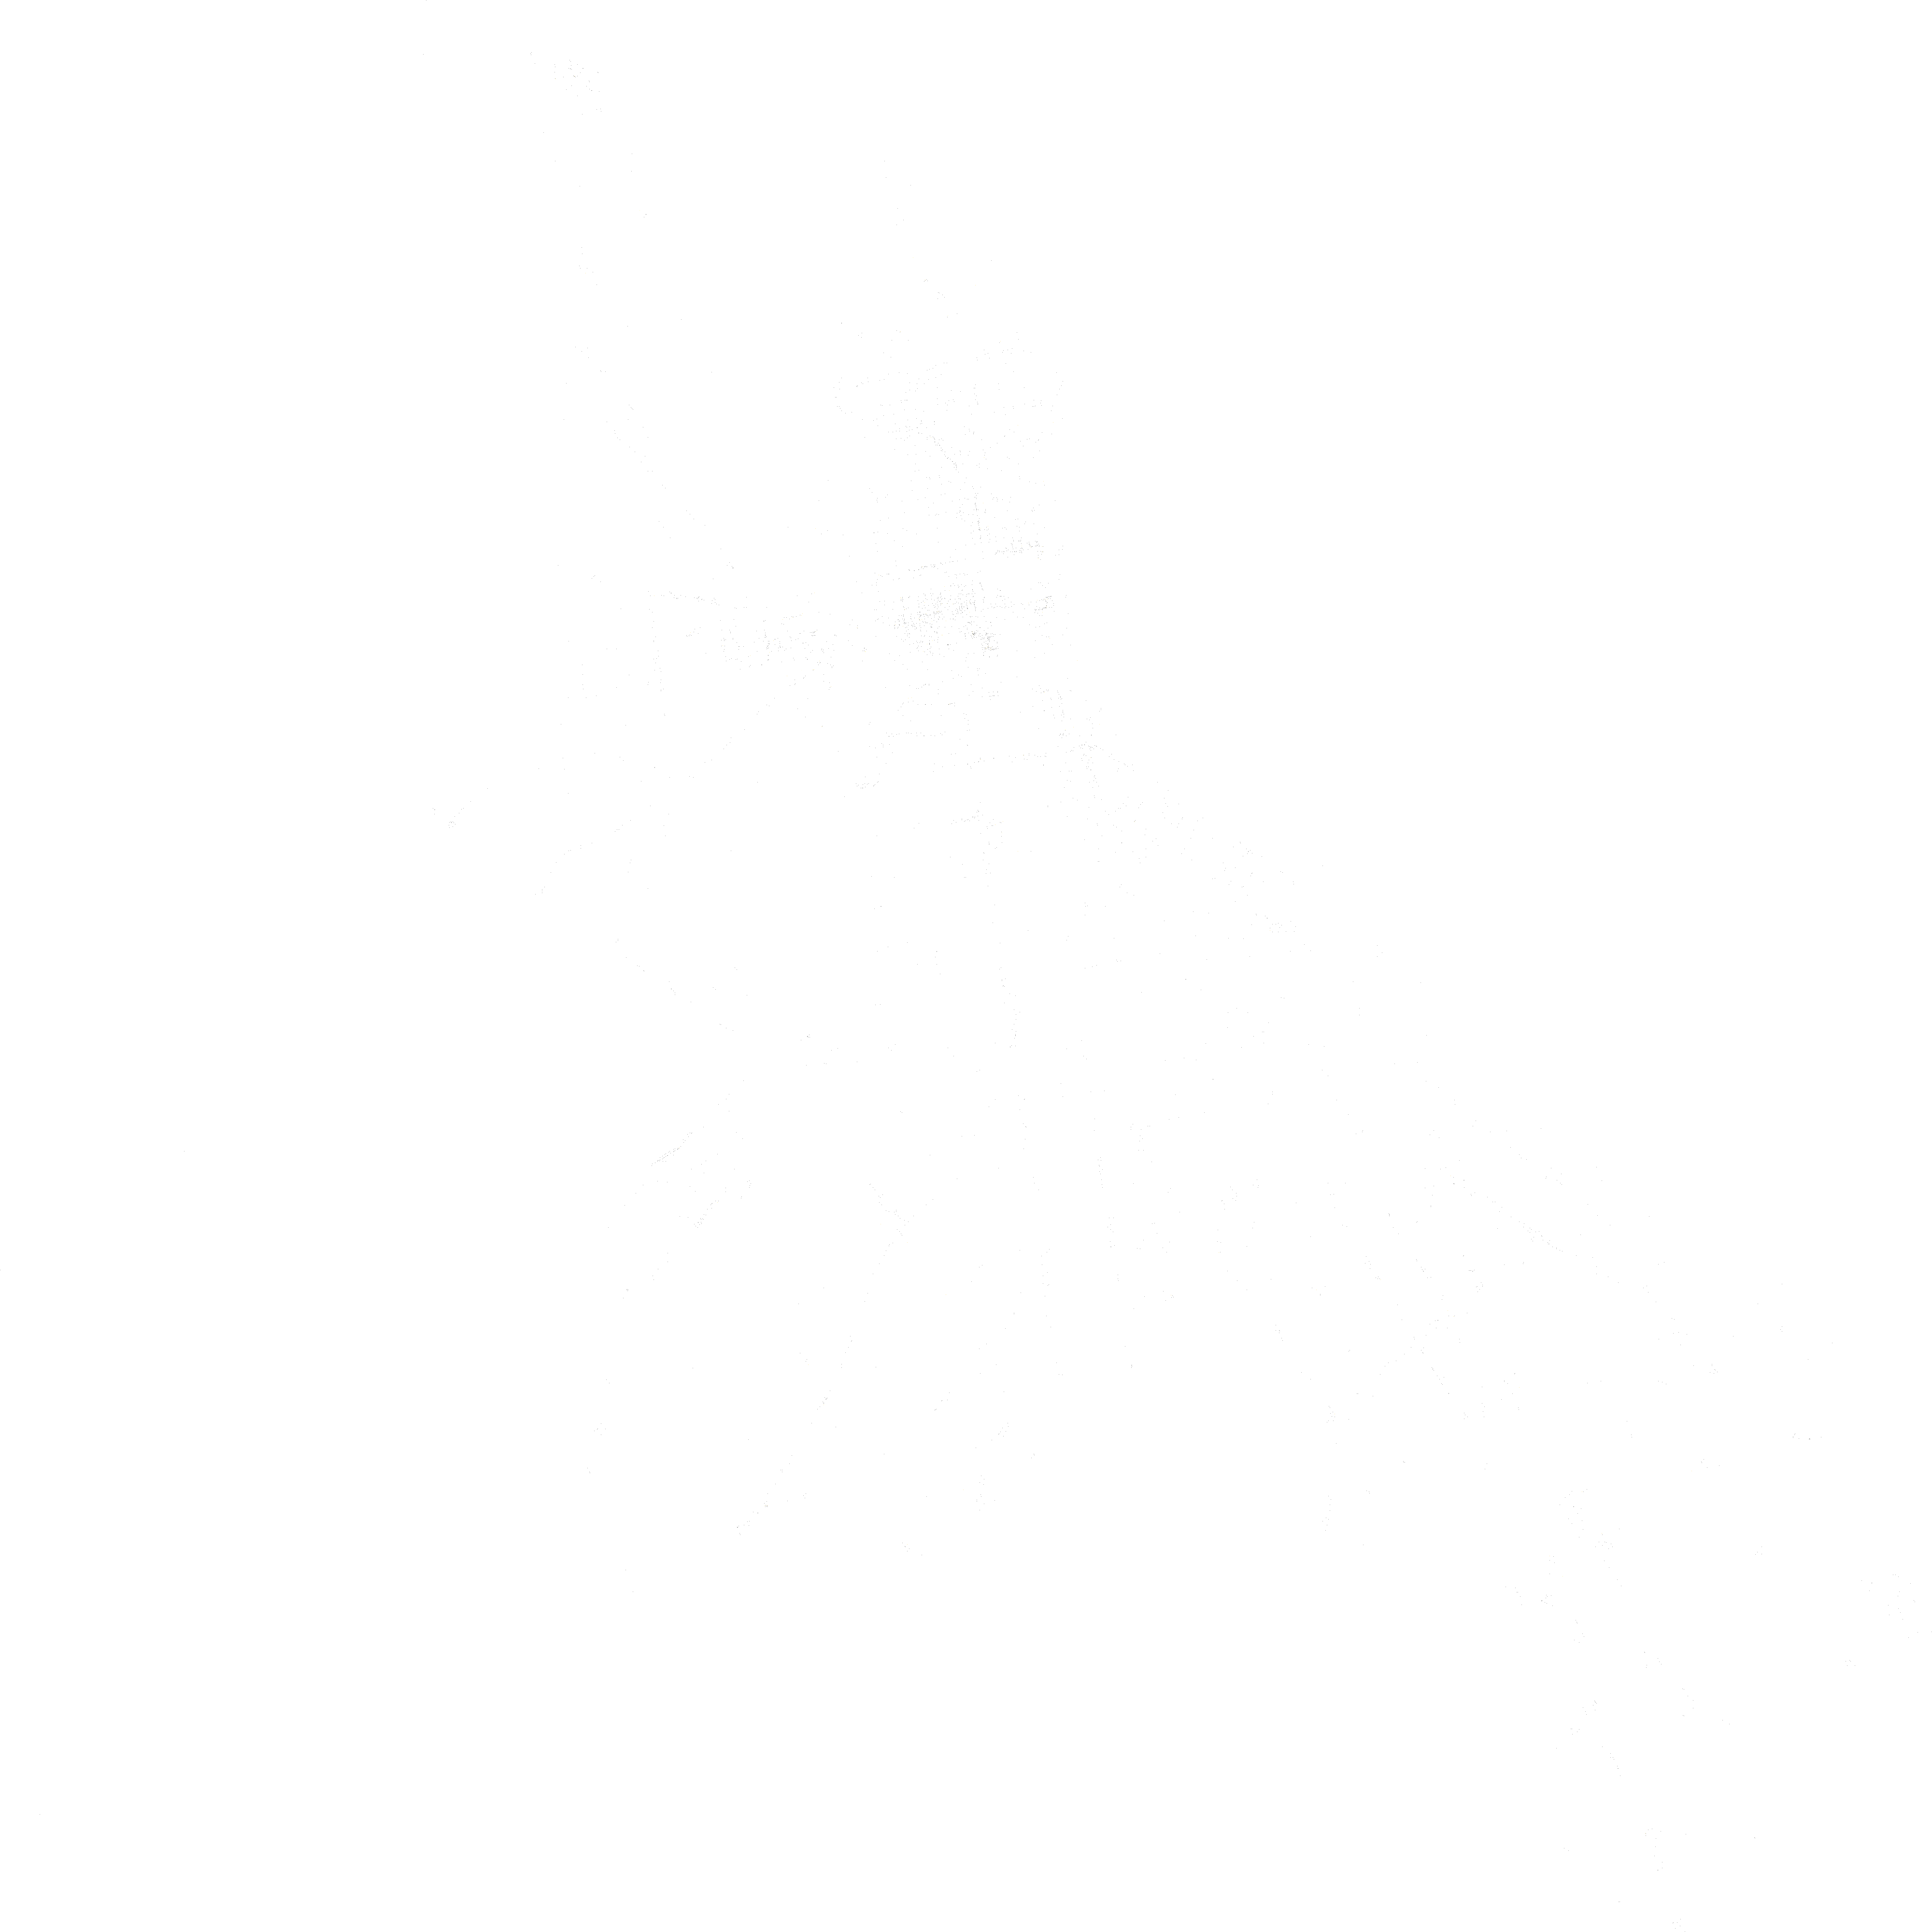

In [ ]:
fig = px.scatter_mapbox(business_final, lat= "latitude", lon="longitude", color="stars",size='review_count', size_max=15, width=1000, height=700, zoom = 10)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

### K-means Clustering

In [ ]:
# Putting the Coordinates of Restaurants together into a dataframe
coordinates = business_final[['longitude','latitude']]
coordinates # Total of 5,471 Locations for 5,471 Unique Restaurants

longitude   latitude
0    -75.155564  39.955505
1    -75.143226  39.953949
2    -75.162568  39.943223
3    -75.135657  39.962582
4    -75.194894  39.954573
...         ...        ...
3520 -75.174728  39.925205
3521 -75.157752  39.970720
3522 -75.189916  39.957447
3523 -75.214430  40.032483
3524 -75.158665  39.935982

[3525 rows x 2 columns]

### Find optimal K using Elbow Method

In [ ]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for i in K:
    kmeansModel = KMeans(n_clusters=i)
    kmeansModel = kmeansModel.fit(coordinates)
    distortions.append(kmeansModel.inertia_)

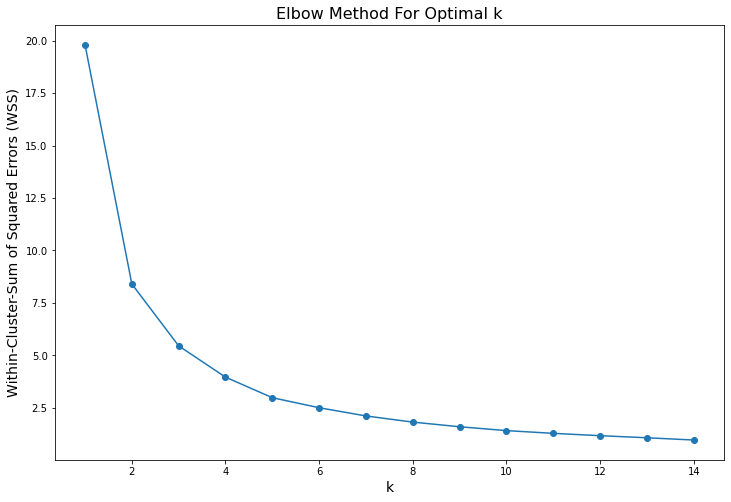

In [ ]:
# Elbow Graph for WSS

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()

### Get Silhouette Score for each K

In [ ]:
# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

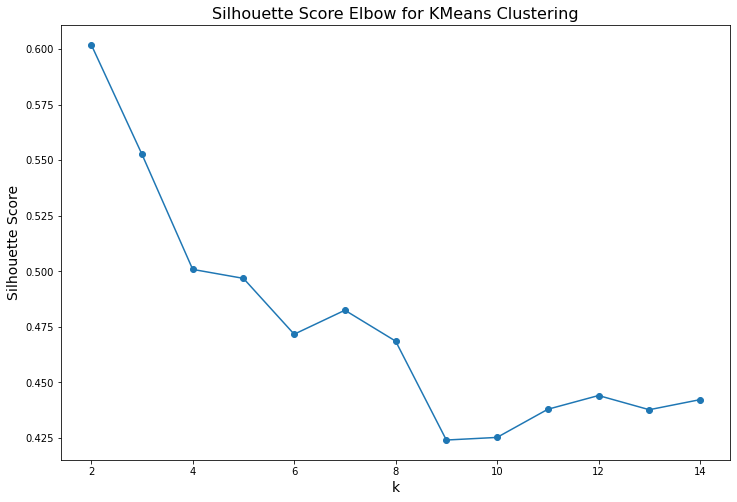

In [ ]:
# Elbow Graph for Silhouette Score

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [ ]:
# Setting K = 4

kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 4  silhouette_score  0.5008537800061502


In [ ]:
business_final['init_cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

business_id                name  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa   

                                                                                                      categories  \
0                                                          Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries   
1                                                                              Sushi Bars, Restaurants, Japanese   
2                                                                                            Korean, Restaurants   
3  Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants   
4               Restaurants, Automotive, Delis, Gas Stations, Food, Coffee & Tea, Sandwiches, Convenience Stores   

   stars  review_count   latitude  longitude  postal_code  init_cluster  
0    4.0            80  39.955505 -75.155564        19107             0  
1    4.0           245  39.953949 -75.143226        19106             0  
2    4.5           205  39.943223 -75.162568        19147             0  
3    3.5            65  39.962582 -75.135657        19123             0  
4    3.0            56  39.954573 -75.194894        19104             3

### Plot the Clustered Restaurants on World Map

In [ ]:
cvs = ds.Canvas(plot_width=4000, plot_height=4000)
agg = cvs.points(business_final, x='longitude', y='latitude')
# agg is an xarray object
coords_lat, coords_lon = agg.coords['latitude'].values, agg.coords['longitude'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [ ]:
img=(tf.shade(agg, cmap = fire, how='eq_hist', alpha = 100))[::-1].to_pil() #pil stands for Python Image Library


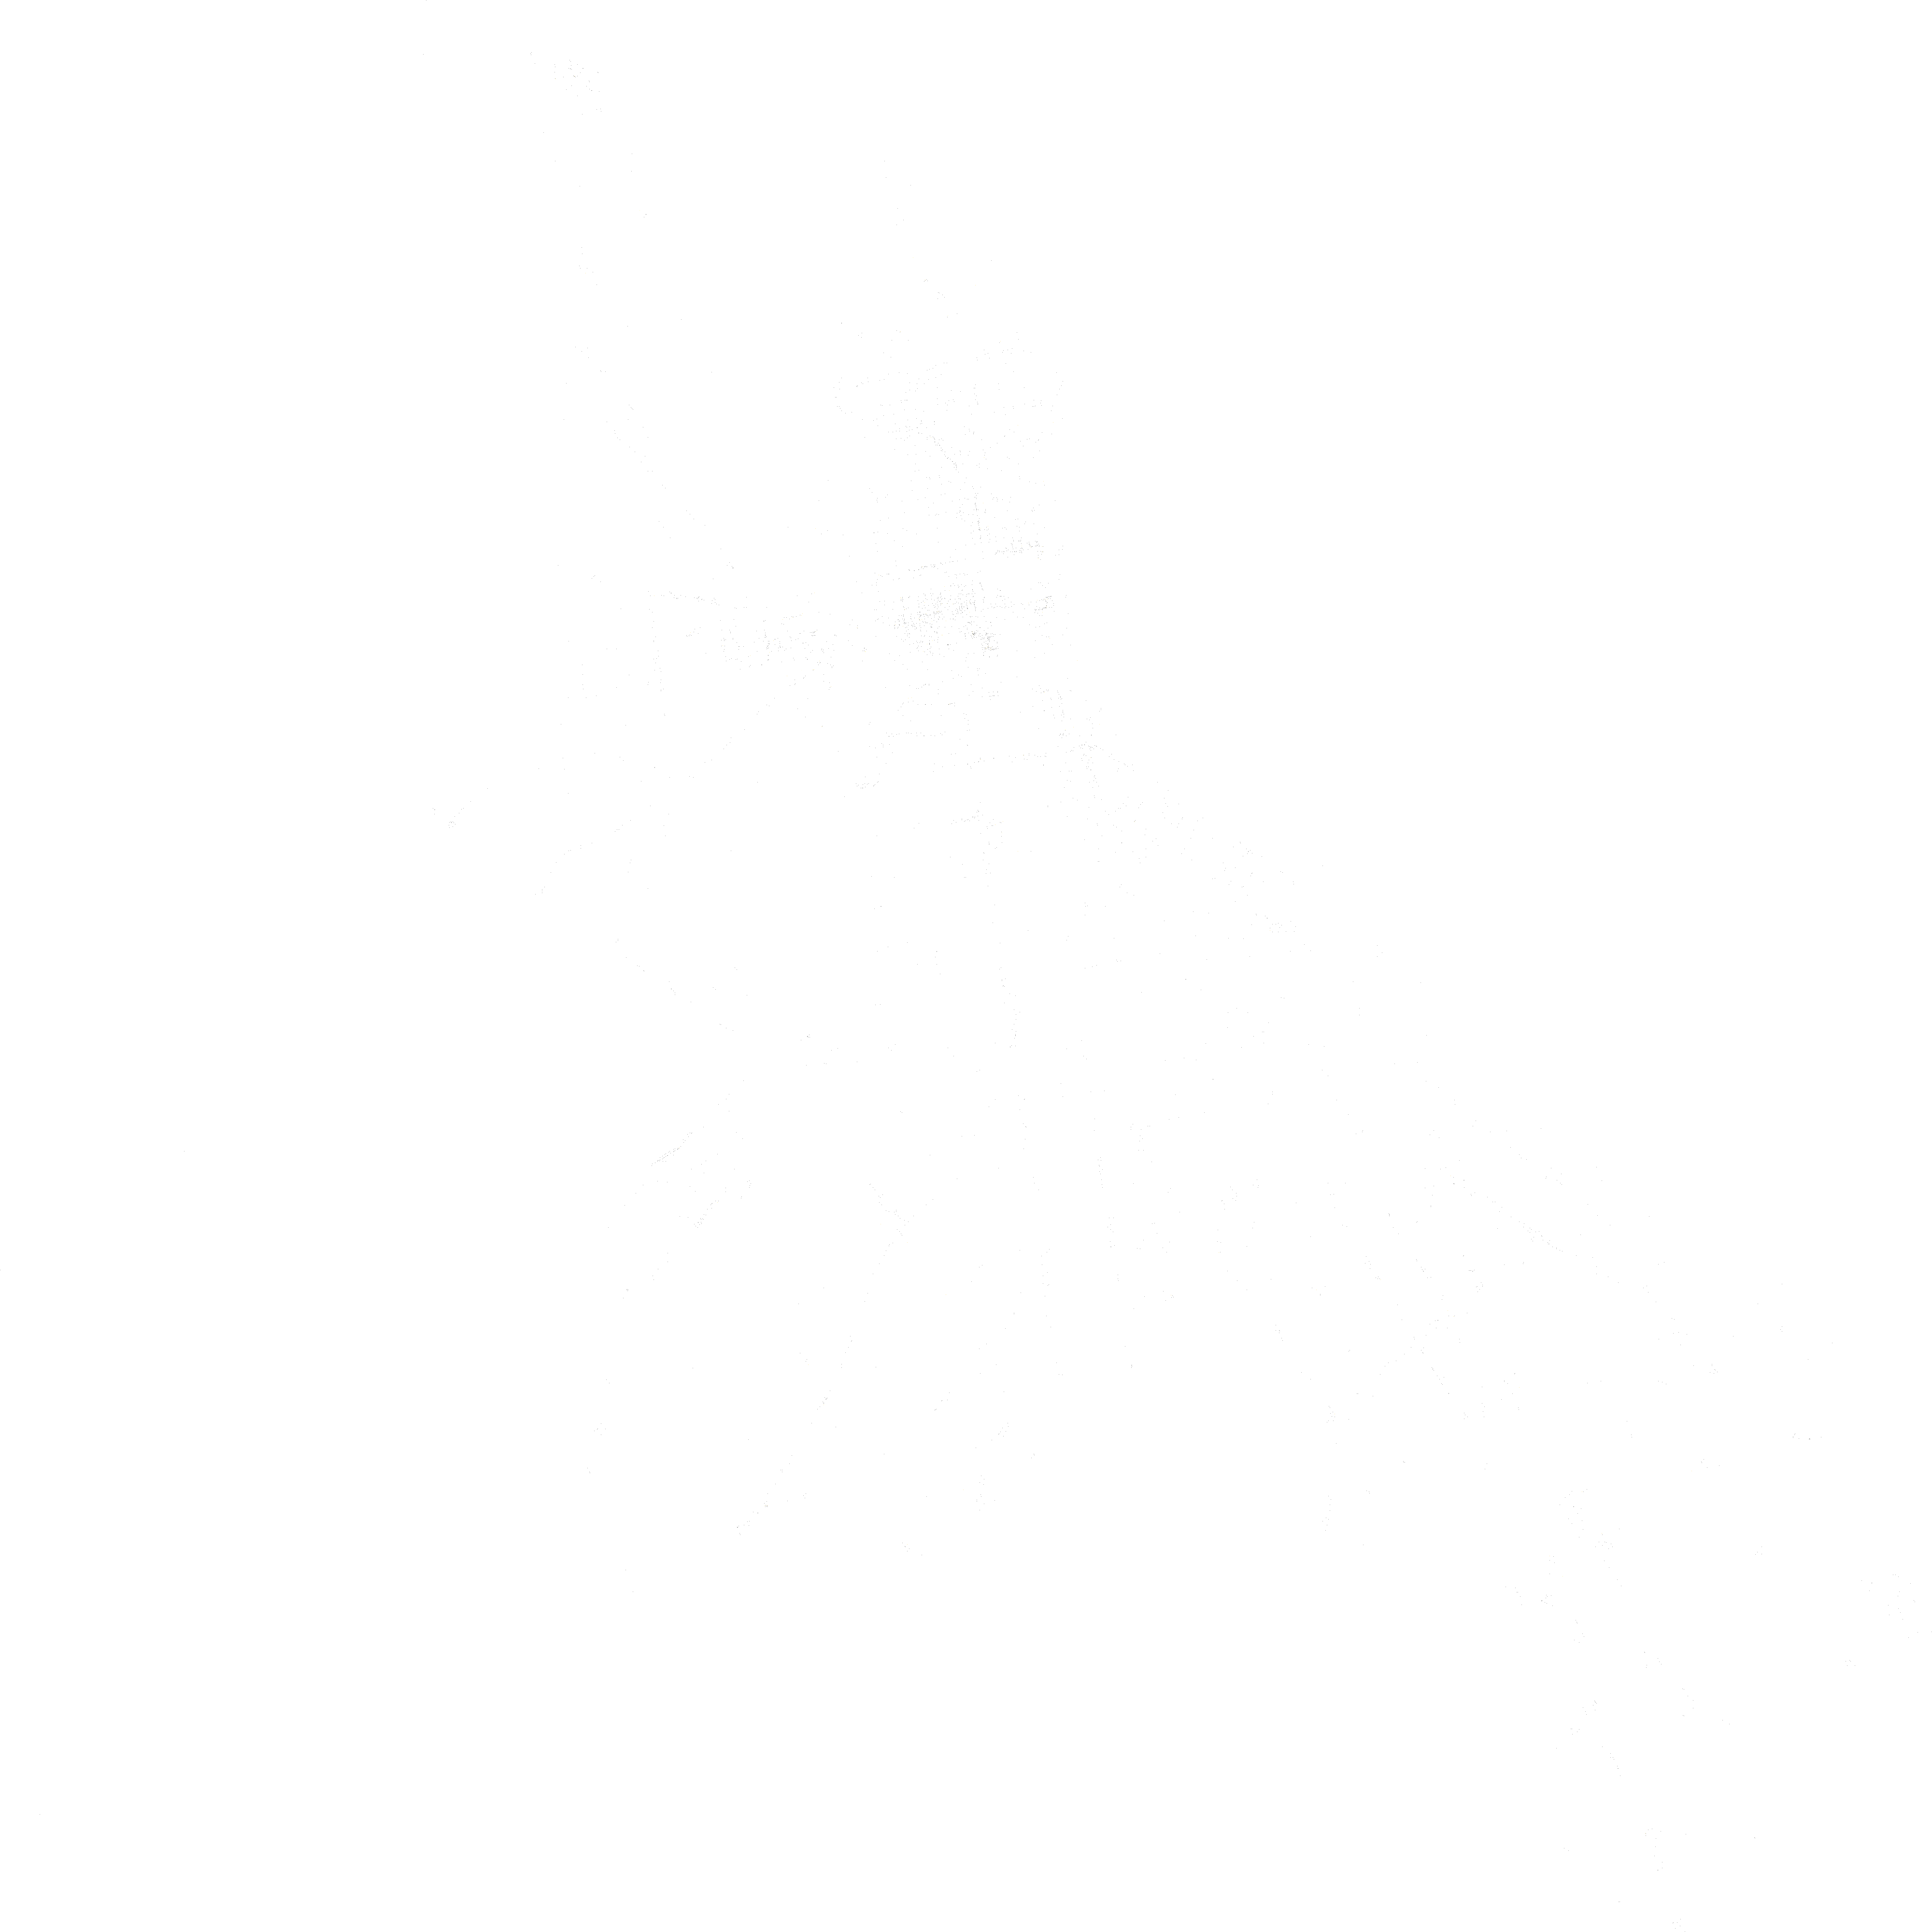

In [ ]:
fig = px.scatter_mapbox(business_final, lat= "latitude", lon="longitude", color="init_cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

In [ ]:
# Putting the Coordinates of Restaurants together into a dataframe
coordinates = business_final[['longitude','latitude']]
coordinates

longitude   latitude
0    -75.155564  39.955505
1    -75.143226  39.953949
2    -75.162568  39.943223
3    -75.135657  39.962582
4    -75.194894  39.954573
...         ...        ...
3520 -75.174728  39.925205
3521 -75.157752  39.970720
3522 -75.189916  39.957447
3523 -75.214430  40.032483
3524 -75.158665  39.935982

[3525 rows x 2 columns]

In [ ]:
#k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

k = 10  silhouette_score  0.4329873479651259


In [ ]:
business_final['cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

business_id                name  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa   

                                                                                                      categories  \
0                                                          Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries   
1                                                                              Sushi Bars, Restaurants, Japanese   
2                                                                                            Korean, Restaurants   
3  Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food, Restaurants   
4               Restaurants, Automotive, Delis, Gas Stations, Food, Coffee & Tea, Sandwiches, Convenience Stores   

   stars  review_count   latitude  longitude  postal_code  init_cluster  \
0    4.0            80  39.955505 -75.155564        19107             0   
1    4.0           245  39.953949 -75.143226        19106             0   
2    4.5           205  39.943223 -75.162568        19147             0   
3    3.5            65  39.962582 -75.135657        19123             0   
4    3.0            56  39.954573 -75.194894        19104             3   

   cluster  
0        4  
1        4  
2        4  
3        2  
4        0

In [ ]:
cvs = ds.Canvas(plot_width=4000, plot_height=4000)
agg = cvs.points(business_final, x='longitude', y='latitude')
# agg is an xarray object
coords_lat, coords_lon = agg.coords['latitude'].values, agg.coords['longitude'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

In [ ]:
img=(tf.shade(agg, cmap = fire, how='eq_hist', alpha = 100))[::-1].to_pil()


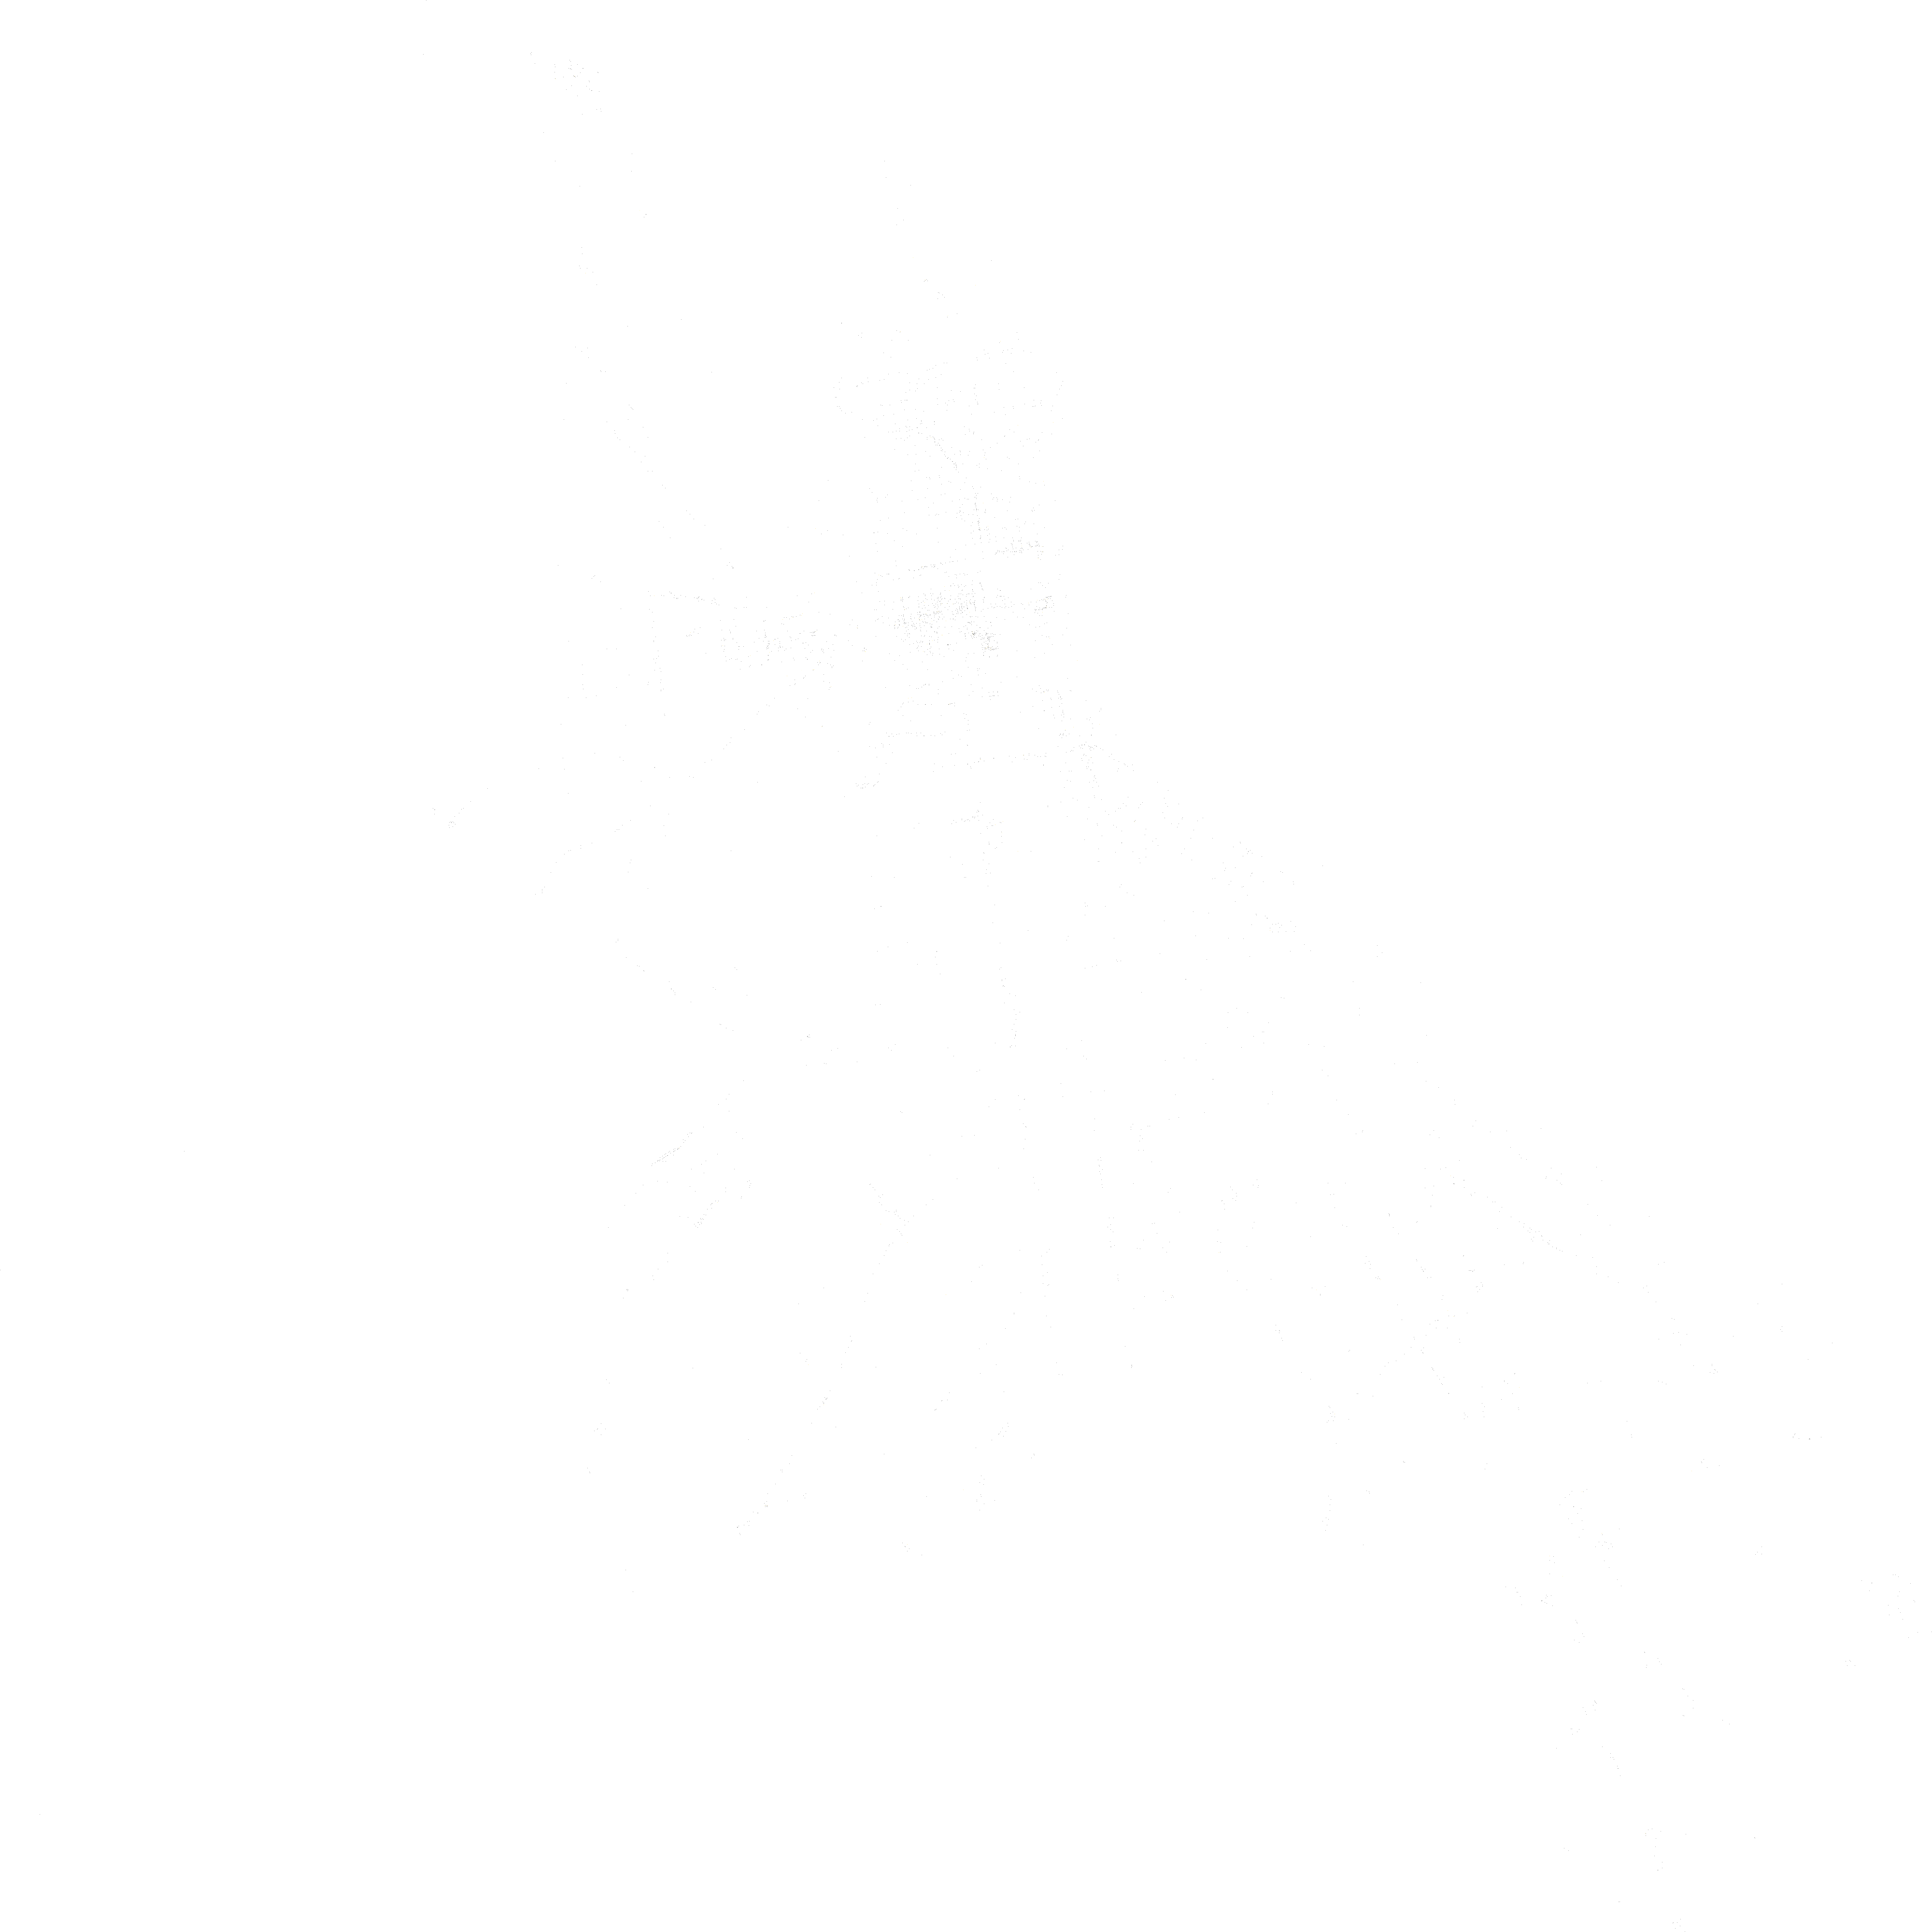

In [ ]:
fig = px.scatter_mapbox(business_final, lat= "latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=800)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

In [ ]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_philadelphia = business_final.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_philadelphia.head()

business_id                   name  \
1645  TE2IEDNV0RcI6s1wTOP4fg  Tortilleria San Roman   
2791  Ktg3ahIxk0JIkJwXAqu2ew           Hikari Sushi   
3312  kT8IlV47kz1rz2lTuNyO1w        Christie's Deli   
2019  UMHuKs1sO-wq3XqKaejXeA   Miss Rachel's Pantry   
1878  gvD09Ev1aOmphtlq07zYEA        El Rancho Viejo   

                                                                                                                                  categories  \
1645                                                                 Convenience Stores, Italian, Specialty Food, Mexican, Restaurants, Food   
2791                                                                                                       Restaurants, Sushi Bars, Japanese   
3312                                                                                      Restaurants, Breakfast & Brunch, Delis, Sandwiches   
2019  Arts & Crafts, Food, Shopping, Food Delivery Services, Event Planning & Services, Cafes, Vegan, Restaurants, Caterers, Cooking Classes   
1878                                                                                                                    Restaurants, Mexican   

      stars  review_count   latitude  longitude  postal_code  init_cluster  \
1645    5.0           219  39.937636 -75.158082        19147             0   
2791    5.0           155  39.967402 -75.141153        19123             0   
3312    5.0           152  39.963081 -75.169360        19130             0   
2019    5.0           119  39.926515 -75.173776        19145             0   
1878    5.0           110  39.936282 -75.152142        19147             0   

      cluster  
1645        4  
2791        2  
3312        4  
2019        8  
1878        8

In [ ]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [39.967402, 43.6701, 43.6546],
    'longitude' : [-75.141153, -79.2988, -79.4452],
}

test_df = pd.DataFrame(test_coordinates)

In [ ]:
user1 = test_df[test_df['user'] == 1]
user1

user   latitude  longitude
0     1  39.967402 -75.141153

# Collaborative Filtering

In [ ]:
reviews = pd.read_csv('/content/drive/MyDrive/USML_Project/reviews_topic_modeling.csv')

In [ ]:
business = pd.read_csv ('/content/drive/MyDrive/USML_Project/business_philadelphia.csv')

In [ ]:
# Filtering for Selected Columns

final_df = reviews[['business_id', 'user_id', 'super_score', 'Keywords', 'stars_yelp']]
final_df.head(3)

business_id                 user_id  super_score  \
0  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ     5.302167   
1  kxX2SOes4o-D3ZQBkiMRfA  kSMOJwJXuEUqzfmuFncK4A     1.975839   
2  kxX2SOes4o-D3ZQBkiMRfA  mqBWACmaHflW4eh_Ofp16Q     5.131585   

                                            Keywords  stars_yelp  
0  order, food, ask, give, time, tell, service, m...         4.0  
1  order, chicken, sauce, taste, fry, flavor, fre...         4.0  
2  order, chicken, sauce, taste, fry, flavor, fre...         4.0

In [ ]:
philadelphia_restaurant = business[['business_id', 'name', 'categories']]
philadelphia_restaurant.head()

business_id                name  \
0  MTSW4McQd7CbVtyjqoe9mw  St Honore Pastries   
1  MUTTqe8uqyMdBl186RmNeA            Tuna Bar   
2  ROeacJQwBeh05Rqg7F6TCg                 BAP   
3  aPNXGTDkf-4bjhyMBQxqpQ          Craft Hall   
4  ppFCk9aQkM338Rgwpl2F5A                Wawa   

                                          categories  
0  Restaurants, Food, Bubble Tea, Coffee & Tea, B...  
1                  Sushi Bars, Restaurants, Japanese  
2                                Korean, Restaurants  
3  Eatertainment, Arts & Entertainment, Brewpubs,...  
4  Restaurants, Automotive, Delis, Gas Stations, ...

In [ ]:
# Merging Dataframes

philadelphia_data = pd.merge(final_df, philadelphia_restaurant, on='business_id')
philadelphia_data.head(5)

business_id                 user_id  super_score  \
0  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ     5.302167   
1  kxX2SOes4o-D3ZQBkiMRfA  kSMOJwJXuEUqzfmuFncK4A     1.975839   
2  kxX2SOes4o-D3ZQBkiMRfA  mqBWACmaHflW4eh_Ofp16Q     5.131585   
3  kxX2SOes4o-D3ZQBkiMRfA  Z-xgVb4nM42943m2wbBkFw     5.298653   
4  kxX2SOes4o-D3ZQBkiMRfA  2SEoXb6r6hPKrl9V9VzBgA     5.158852   

                                            Keywords  stars_yelp   name  \
0  order, food, ask, give, time, tell, service, m...         4.0  Zaika   
1  order, chicken, sauce, taste, fry, flavor, fre...         4.0  Zaika   
2  order, chicken, sauce, taste, fry, flavor, fre...         4.0  Zaika   
3  wait, time, place, friend, open, bad, next, ea...         4.0  Zaika   
4  great, food, place, pizza, love, amazing, serv...         4.0  Zaika   

                              categories  
0  Halal, Pakistani, Restaurants, Indian  
1  Halal, Pakistani, Restaurants, Indian  
2  Halal, Pakistani, Restaurants, Indian  
3  Halal, Pakistani, Restaurants, Indian  
4  Halal, Pakistani, Restaurants, Indian

In [ ]:
# Combining the text in Keywords and categories columns
philadelphia_data['All_Keywords'] = philadelphia_data['categories'].str.cat(philadelphia_data['Keywords'],sep=", ")
philadelphia_data.head()

business_id                 user_id  super_score  \
0  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ     5.302167   
1  kxX2SOes4o-D3ZQBkiMRfA  kSMOJwJXuEUqzfmuFncK4A     1.975839   
2  kxX2SOes4o-D3ZQBkiMRfA  mqBWACmaHflW4eh_Ofp16Q     5.131585   
3  kxX2SOes4o-D3ZQBkiMRfA  Z-xgVb4nM42943m2wbBkFw     5.298653   
4  kxX2SOes4o-D3ZQBkiMRfA  2SEoXb6r6hPKrl9V9VzBgA     5.158852   

                                            Keywords  stars_yelp   name  \
0  order, food, ask, give, time, tell, service, m...         4.0  Zaika   
1  order, chicken, sauce, taste, fry, flavor, fre...         4.0  Zaika   
2  order, chicken, sauce, taste, fry, flavor, fre...         4.0  Zaika   
3  wait, time, place, friend, open, bad, next, ea...         4.0  Zaika   
4  great, food, place, pizza, love, amazing, serv...         4.0  Zaika   

                              categories  \
0  Halal, Pakistani, Restaurants, Indian   
1  Halal, Pakistani, Restaurants, Indian   
2  Halal, Pakistani, Restaurants, Indian   
3  Halal, Pakistani, Restaurants, Indian   
4  Halal, Pakistani, Restaurants, Indian   

                                        All_Keywords  
0  Halal, Pakistani, Restaurants, Indian, order, ...  
1  Halal, Pakistani, Restaurants, Indian, order, ...  
2  Halal, Pakistani, Restaurants, Indian, order, ...  
3  Halal, Pakistani, Restaurants, Indian, wait, t...  
4  Halal, Pakistani, Restaurants, Indian, great, ...

In [ ]:
philadelphia_data.to_csv('/content/drive/MyDrive/USML_Project/final_philadelphia.csv', index = False)

### Create User-Item Matrix based on Super Scores

In [ ]:
# Creating the Matrix by using the Pivot Table Function
philadelphia_restaurant_rating = philadelphia_data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
philadelphia_restaurant_rating.head()

name                    $5 Fresh Burger Stop  &pizza - UPenn  &pizza - Walnut  \
user_id                                                                         
--2tyArRmSoyKx5r-FVG0A                   NaN             NaN              NaN   
--2vR0DIsmQ6WfcSzKWigw                   NaN             NaN              NaN   
--4AjktZiHowEIBCMd4CZA                   NaN             NaN              NaN   
--4_p6Z3tKadJcr9Non_Vw                   NaN             NaN              NaN   
--6GckBYtTa4hj8pT09oAg                   NaN             NaN              NaN   

name                    1 Stop Pizza  1100 Social  1201 Bar  \
user_id                                                       
--2tyArRmSoyKx5r-FVG0A           NaN          NaN       NaN   
--2vR0DIsmQ6WfcSzKWigw           NaN          NaN       NaN   
--4AjktZiHowEIBCMd4CZA           NaN          NaN       NaN   
--4_p6Z3tKadJcr9Non_Vw           NaN          NaN       NaN   
--6GckBYtTa4hj8pT09oAg           NaN          NaN       NaN   

name                    1225Raw Sushi and Sake Lounge  13 Restaurant  \
user_id                                                                
--2tyArRmSoyKx5r-FVG0A                            NaN            NaN   
--2vR0DIsmQ6WfcSzKWigw                            NaN            NaN   
--4AjktZiHowEIBCMd4CZA                            NaN            NaN   
--4_p6Z3tKadJcr9Non_Vw                            NaN            NaN   
--6GckBYtTa4hj8pT09oAg                            NaN            NaN   

name                    1518 Bar & Grill  16th Street Seafood  ...  honeygrow  \
user_id                                                        ...              
--2tyArRmSoyKx5r-FVG0A               NaN                  NaN  ...        NaN   
--2vR0DIsmQ6WfcSzKWigw               NaN                  NaN  ...        NaN   
--4AjktZiHowEIBCMd4CZA               NaN                  NaN  ...        NaN   
--4_p6Z3tKadJcr9Non_Vw               NaN                  NaN  ...        NaN   
--6GckBYtTa4hj8pT09oAg               NaN                  NaN  ...        NaN   

name                    iMunch Cafe  iPho  iPho Vietnamese Restaurant  \
user_id                                                                 
--2tyArRmSoyKx5r-FVG0A          NaN   NaN                         NaN   
--2vR0DIsmQ6WfcSzKWigw          NaN   NaN                         NaN   
--4AjktZiHowEIBCMd4CZA          NaN   NaN                         NaN   
--4_p6Z3tKadJcr9Non_Vw          NaN   NaN                         NaN   
--6GckBYtTa4hj8pT09oAg          NaN   NaN                         NaN   

name                    la bamba  moonbowls  nunu  penrose cheesesteak  \
user_id                                                                  
--2tyArRmSoyKx5r-FVG0A       NaN        NaN   NaN                  NaN   
--2vR0DIsmQ6WfcSzKWigw       NaN        NaN   NaN                  NaN   
--4AjktZiHowEIBCMd4CZA       NaN        NaN   NaN                  NaN   
--4_p6Z3tKadJcr9Non_Vw       NaN        NaN   NaN                  NaN   
--6GckBYtTa4hj8pT09oAg       NaN        NaN   NaN                  NaN   

name                    revive 21  sweetgreen  
user_id                                        
--2tyArRmSoyKx5r-FVG0A        NaN         NaN  
--2vR0DIsmQ6WfcSzKWigw        NaN         NaN  
--4AjktZiHowEIBCMd4CZA        NaN         NaN  
--4_p6Z3tKadJcr9Non_Vw        NaN         NaN  
--6GckBYtTa4hj8pT09oAg        NaN         NaN  

[5 rows x 3043 columns]

### Normalize Ratings by Subtracting the Average.

In [ ]:
# Normalizing the Rating Scores

def mean_center_rows(df):
    return (df.T - df.mean(axis = 1)).T

philadelphia_restaurant_rating = mean_center_rows(philadelphia_restaurant_rating)
philadelphia_restaurant_rating.head()

name                    $5 Fresh Burger Stop  &pizza - UPenn  &pizza - Walnut  \
user_id                                                                         
--2tyArRmSoyKx5r-FVG0A                   NaN             NaN              NaN   
--2vR0DIsmQ6WfcSzKWigw                   NaN             NaN              NaN   
--4AjktZiHowEIBCMd4CZA                   NaN             NaN              NaN   
--4_p6Z3tKadJcr9Non_Vw                   NaN             NaN              NaN   
--6GckBYtTa4hj8pT09oAg                   NaN             NaN              NaN   

name                    1 Stop Pizza  1100 Social  1201 Bar  \
user_id                                                       
--2tyArRmSoyKx5r-FVG0A           NaN          NaN       NaN   
--2vR0DIsmQ6WfcSzKWigw           NaN          NaN       NaN   
--4AjktZiHowEIBCMd4CZA           NaN          NaN       NaN   
--4_p6Z3tKadJcr9Non_Vw           NaN          NaN       NaN   
--6GckBYtTa4hj8pT09oAg           NaN          NaN       NaN   

name                    1225Raw Sushi and Sake Lounge  13 Restaurant  \
user_id                                                                
--2tyArRmSoyKx5r-FVG0A                            NaN            NaN   
--2vR0DIsmQ6WfcSzKWigw                            NaN            NaN   
--4AjktZiHowEIBCMd4CZA                            NaN            NaN   
--4_p6Z3tKadJcr9Non_Vw                            NaN            NaN   
--6GckBYtTa4hj8pT09oAg                            NaN            NaN   

name                    1518 Bar & Grill  16th Street Seafood  ...  honeygrow  \
user_id                                                        ...              
--2tyArRmSoyKx5r-FVG0A               NaN                  NaN  ...        NaN   
--2vR0DIsmQ6WfcSzKWigw               NaN                  NaN  ...        NaN   
--4AjktZiHowEIBCMd4CZA               NaN                  NaN  ...        NaN   
--4_p6Z3tKadJcr9Non_Vw               NaN                  NaN  ...        NaN   
--6GckBYtTa4hj8pT09oAg               NaN                  NaN  ...        NaN   

name                    iMunch Cafe  iPho  iPho Vietnamese Restaurant  \
user_id                                                                 
--2tyArRmSoyKx5r-FVG0A          NaN   NaN                         NaN   
--2vR0DIsmQ6WfcSzKWigw          NaN   NaN                         NaN   
--4AjktZiHowEIBCMd4CZA          NaN   NaN                         NaN   
--4_p6Z3tKadJcr9Non_Vw          NaN   NaN                         NaN   
--6GckBYtTa4hj8pT09oAg          NaN   NaN                         NaN   

name                    la bamba  moonbowls  nunu  penrose cheesesteak  \
user_id                                                                  
--2tyArRmSoyKx5r-FVG0A       NaN        NaN   NaN                  NaN   
--2vR0DIsmQ6WfcSzKWigw       NaN        NaN   NaN                  NaN   
--4AjktZiHowEIBCMd4CZA       NaN        NaN   NaN                  NaN   
--4_p6Z3tKadJcr9Non_Vw       NaN        NaN   NaN                  NaN   
--6GckBYtTa4hj8pT09oAg       NaN        NaN   NaN                  NaN   

name                    revive 21  sweetgreen  
user_id                                        
--2tyArRmSoyKx5r-FVG0A        NaN         NaN  
--2vR0DIsmQ6WfcSzKWigw        NaN         NaN  
--4AjktZiHowEIBCMd4CZA        NaN         NaN  
--4_p6Z3tKadJcr9Non_Vw        NaN         NaN  
--6GckBYtTa4hj8pT09oAg        NaN         NaN  

[5 rows x 3043 columns]

In [ ]:
# Filling all Null Values with 0.0

philadelphia_restaurant_rating = philadelphia_restaurant_rating.fillna(0)
philadelphia_restaurant_rating.head()

name                    $5 Fresh Burger Stop  &pizza - UPenn  &pizza - Walnut  \
user_id                                                                         
--2tyArRmSoyKx5r-FVG0A                   0.0             0.0              0.0   
--2vR0DIsmQ6WfcSzKWigw                   0.0             0.0              0.0   
--4AjktZiHowEIBCMd4CZA                   0.0             0.0              0.0   
--4_p6Z3tKadJcr9Non_Vw                   0.0             0.0              0.0   
--6GckBYtTa4hj8pT09oAg                   0.0             0.0              0.0   

name                    1 Stop Pizza  1100 Social  1201 Bar  \
user_id                                                       
--2tyArRmSoyKx5r-FVG0A           0.0          0.0       0.0   
--2vR0DIsmQ6WfcSzKWigw           0.0          0.0       0.0   
--4AjktZiHowEIBCMd4CZA           0.0          0.0       0.0   
--4_p6Z3tKadJcr9Non_Vw           0.0          0.0       0.0   
--6GckBYtTa4hj8pT09oAg           0.0          0.0       0.0   

name                    1225Raw Sushi and Sake Lounge  13 Restaurant  \
user_id                                                                
--2tyArRmSoyKx5r-FVG0A                            0.0            0.0   
--2vR0DIsmQ6WfcSzKWigw                            0.0            0.0   
--4AjktZiHowEIBCMd4CZA                            0.0            0.0   
--4_p6Z3tKadJcr9Non_Vw                            0.0            0.0   
--6GckBYtTa4hj8pT09oAg                            0.0            0.0   

name                    1518 Bar & Grill  16th Street Seafood  ...  honeygrow  \
user_id                                                        ...              
--2tyArRmSoyKx5r-FVG0A               0.0                  0.0  ...        0.0   
--2vR0DIsmQ6WfcSzKWigw               0.0                  0.0  ...        0.0   
--4AjktZiHowEIBCMd4CZA               0.0                  0.0  ...        0.0   
--4_p6Z3tKadJcr9Non_Vw               0.0                  0.0  ...        0.0   
--6GckBYtTa4hj8pT09oAg               0.0                  0.0  ...        0.0   

name                    iMunch Cafe  iPho  iPho Vietnamese Restaurant  \
user_id                                                                 
--2tyArRmSoyKx5r-FVG0A          0.0   0.0                         0.0   
--2vR0DIsmQ6WfcSzKWigw          0.0   0.0                         0.0   
--4AjktZiHowEIBCMd4CZA          0.0   0.0                         0.0   
--4_p6Z3tKadJcr9Non_Vw          0.0   0.0                         0.0   
--6GckBYtTa4hj8pT09oAg          0.0   0.0                         0.0   

name                    la bamba  moonbowls  nunu  penrose cheesesteak  \
user_id                                                                  
--2tyArRmSoyKx5r-FVG0A       0.0        0.0   0.0                  0.0   
--2vR0DIsmQ6WfcSzKWigw       0.0        0.0   0.0                  0.0   
--4AjktZiHowEIBCMd4CZA       0.0        0.0   0.0                  0.0   
--4_p6Z3tKadJcr9Non_Vw       0.0        0.0   0.0                  0.0   
--6GckBYtTa4hj8pT09oAg       0.0        0.0   0.0                  0.0   

name                    revive 21  sweetgreen  
user_id                                        
--2tyArRmSoyKx5r-FVG0A        0.0         0.0  
--2vR0DIsmQ6WfcSzKWigw        0.0         0.0  
--4AjktZiHowEIBCMd4CZA        0.0         0.0  
--4_p6Z3tKadJcr9Non_Vw        0.0         0.0  
--6GckBYtTa4hj8pT09oAg        0.0         0.0  

[5 rows x 3043 columns]

### Check Mean Scores across User Ids and Business Ids

In [ ]:
# Check Mean scores across user_ids

philadelphia_restaurant_rating.mean(axis=1)

user_id
--2tyArRmSoyKx5r-FVG0A    0.000000e+00
--2vR0DIsmQ6WfcSzKWigw    0.000000e+00
--4AjktZiHowEIBCMd4CZA   -1.167504e-18
--4_p6Z3tKadJcr9Non_Vw    0.000000e+00
--6GckBYtTa4hj8pT09oAg    0.000000e+00
                              ...     
zzu2hGJ6O9mP5yg6fjtvzg    0.000000e+00
zzvCl_egPyWpxO7EvWc2IA    0.000000e+00
zzwYLnmIvj8C7wJmRjtkRA   -2.918759e-19
zzx7J3zheFF3zf5YYfDAMg    0.000000e+00
zzzMBVS73g3ZJ7qL8JyhiA    0.000000e+00
Length: 177997, dtype: float64

In [ ]:
philadelphia_restaurant_rating.mean(axis=1).isnull().sum()

0

In [ ]:
# Check Mean scores across business_ids
philadelphia_restaurant_rating.mean(axis = 0)

name
$5 Fresh Burger Stop    0.000012
&pizza - UPenn          0.000040
&pizza - Walnut         0.000404
1 Stop Pizza            0.000015
1100 Social            -0.000078
                          ...   
moonbowls               0.000012
nunu                   -0.000068
penrose cheesesteak     0.000018
revive 21              -0.000059
sweetgreen             -0.000120
Length: 3043, dtype: float64

In [ ]:
philadelphia_restaurant_rating.mean(axis = 0).isnull().sum()

0

### Truncated SVD to get Latent Features

In [ ]:
# Converting the Matrix DataFrame into a NumPy array

philadelphia_matrix = philadelphia_restaurant_rating.to_numpy()
philadelphia_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Applying Singular Value Decomposition (SVD)

#The number of factors to factor the user-item matrix.
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS_MF = 25

#Performs matrix factorization of the original user item matrix

U, sigma, Vt = svds(philadelphia_matrix, k = NUMBER_OF_FACTORS_MF)

print(U.shape)
print(Vt.shape)

sigma = np.diag(sigma)
sigma.shape

(177997, 25)
(25, 3043)


(25, 25)

### Predict User Ratings based on SVD

In [ ]:
# Overview of user ratings across all Restaurants in Philadelphia

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-1.77419631e-06,  2.92368774e-05, -1.76005513e-04, ...,
        -1.78417152e-06,  1.24487165e-06,  4.35550098e-05],
       [ 2.00162959e-07,  3.83353528e-05,  1.16796463e-04, ...,
         5.19463567e-07, -5.04855601e-06, -1.87843002e-04],
       [ 1.71070708e-05, -2.30358522e-05,  1.31949504e-04, ...,
         3.55863084e-06, -5.42605013e-07,  3.09983191e-05],
       ...,
       [-3.55906351e-06,  1.26536184e-04,  1.01777725e-03, ...,
        -1.33838034e-06,  1.12144094e-05, -6.31966172e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
# Converting the reconstructed matrix back to a Pandas dataframe
# List of first 10 Yelp Customer User_ids in the Matrix
user_ids = list(philadelphia_restaurant_rating.index)

cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = philadelphia_restaurant_rating.columns, index=user_ids).transpose()
print(cf_preds_df.shape)
cf_preds_df.head(10)

(3043, 177997)


--2tyArRmSoyKx5r-FVG0A  --2vR0DIsmQ6WfcSzKWigw  \
name                                                                            
$5 Fresh Burger Stop                    -1.774196e-06            2.001630e-07   
&pizza - UPenn                           2.923688e-05            3.833535e-05   
&pizza - Walnut                         -1.760055e-04            1.167965e-04   
1 Stop Pizza                            -1.636494e-06           -1.120771e-07   
1100 Social                              3.490676e-05            4.690020e-06   
1201 Bar                                -6.816821e-06            3.148371e-06   
1225Raw Sushi and Sake Lounge            6.334049e-04           -1.139002e-04   
13 Restaurant                            1.434373e-04           -3.511054e-05   
1518 Bar & Grill                         1.257029e-04           -4.594342e-05   
16th Street Seafood                      4.699258e-07           -2.413867e-06   

                               --4AjktZiHowEIBCMd4CZA  --4_p6Z3tKadJcr9Non_Vw  \
name                                                                            
$5 Fresh Burger Stop                         0.000017                     0.0   
&pizza - UPenn                              -0.000023                     0.0   
&pizza - Walnut                              0.000132                     0.0   
1 Stop Pizza                                 0.000002                     0.0   
1100 Social                                 -0.000323                     0.0   
1201 Bar                                     0.000001                     0.0   
1225Raw Sushi and Sake Lounge               -0.000512                     0.0   
13 Restaurant                               -0.000056                     0.0   
1518 Bar & Grill                             0.000025                     0.0   
16th Street Seafood                          0.000008                     0.0   

                               --6GckBYtTa4hj8pT09oAg  --6PFZka7og6Khaw6oyjvQ  \
name                                                                            
$5 Fresh Burger Stop                              0.0                0.000065   
&pizza - UPenn                                    0.0                0.000307   
&pizza - Walnut                                   0.0               -0.001745   
1 Stop Pizza                                      0.0               -0.000006   
1100 Social                                       0.0               -0.000253   
1201 Bar                                          0.0               -0.000035   
1225Raw Sushi and Sake Lounge                     0.0                0.000301   
13 Restaurant                                     0.0               -0.000769   
1518 Bar & Grill                                  0.0                0.000771   
16th Street Seafood                               0.0               -0.000366   

                               --9SwR3jQX-e3opxARFF_g  --B0My3yotQA2kLVWz6IYA  \
name                                                                            
$5 Fresh Burger Stop                        -0.000003                     0.0   
&pizza - UPenn                               0.000067                     0.0   
&pizza - Walnut                             -0.000384                     0.0   
1 Stop Pizza                                -0.000004                     0.0   
1100 Social                                  0.000025                     0.0   
1201 Bar                                    -0.000018                     0.0   
1225Raw Sushi and Sake Lounge                0.001558                     0.0   
13 Restaurant                                0.000148                     0.0   
1518 Bar & Grill                             0.000243                     0.0   
16th Street Seafood                         -0.000013                     0.0   

                               --CIuK7sUpaNzalLAlHJKA  --CiqXBj69Uu4YN1WTQ82Q  \
name                                                      

### Create Item-Item Matrix based on Cosine Similarity

In [ ]:
# Creating Item-Item Matrix based on Cosine Similarity

item_item_matrix = cosine_similarity(cf_preds_df)
item_item_matrix= pd.DataFrame(item_item_matrix, columns=cf_preds_df.index, index = cf_preds_df.index)
item_item_matrix

name                  $5 Fresh Burger Stop  &pizza - UPenn  &pizza - Walnut  \
name                                                                          
$5 Fresh Burger Stop              1.000000       -0.021705         0.250638   
&pizza - UPenn                   -0.021705        1.000000        -0.255990   
&pizza - Walnut                   0.250638       -0.255990         1.000000   
1 Stop Pizza                      0.012938       -0.026058        -0.197418   
1100 Social                      -0.110190        0.075996         0.118649   
...                                    ...             ...              ...   
moonbowls                        -0.050828        0.258312        -0.018893   
nunu                             -0.302292        0.122579        -0.248085   
penrose cheesesteak               0.045679       -0.015970        -0.045105   
revive 21                        -0.602490       -0.119116        -0.029287   
sweetgreen                        0.150616       -0.246055        -0.110282   

name                  1 Stop Pizza  1100 Social  1201 Bar  \
name                                                        
$5 Fresh Burger Stop      0.012938    -0.110190  0.398999   
&pizza - UPenn           -0.026058     0.075996 -0.193385   
&pizza - Walnut          -0.197418     0.118649  0.464177   
1 Stop Pizza              1.000000     0.011143  0.228432   
1100 Social               0.011143     1.000000 -0.005163   
...                            ...          ...       ...   
moonbowls                -0.001099    -0.109923 -0.185781   
nunu                      0.004569     0.227744 -0.374833   
penrose cheesesteak       0.350640    -0.187287  0.136802   
revive 21                 0.040998     0.144394 -0.266766   
sweetgreen                0.079691     0.134726 -0.054450   

name                  1225Raw Sushi and Sake Lounge  13 Restaurant  \
name                                                                 
$5 Fresh Burger Stop                      -0.404996      -0.480838   
&pizza - UPenn                             0.511339       0.034554   
&pizza - Walnut                           -0.451926      -0.357941   
1 Stop Pizza                              -0.052802       0.031176   
1100 Social                                0.049398      -0.280912   
...                                             ...            ...   
moonbowls                                  0.104784       0.203556   
nunu                                       0.591978       0.361611   
penrose cheesesteak                       -0.155320       0.084621   
revive 21                                  0.327032       0.310685   
sweetgreen                                -0.145796      -0.004812   

name                  1518 Bar & Grill  16th Street Seafood  ...  honeygrow  \
name                                                         ...              
$5 Fresh Burger Stop         -0.271235            -0.306167  ...  -0.169158   
&pizza - UPenn                0.022115            -0.023195  ...   0.356423   
&pizza - Walnut              -0.607632             0.056072  ...  -0.535795   
1 Stop Pizza                 -0.151057             0.037209  ...   0.014420   
1100 Social                  -0.113750            -0.008938  ...  -0.360925   
...                                ...                  ...  ...        ...   
moonbowls                     0.024096            -0.170413  ...  -0.025685   
nunu                          0.103816             0.074036  ...   0.405901   
penrose cheesesteak          -0.144082            -0.130485  ...  -0.076058   
revive 21                     0.171403             0.441777  ...   0.219670   
sweetgreen                    0.215843             0.021692  ...   0.043406   

name                  iMunch Cafe      iPho  iPho Vietnamese Restaurant  \
name                                                                      
$5 Fresh Burger Stop    -0.168339  0.479532                   -0.233214   
&pizza - UPenn

# Content-Based Filtering

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/USML_Project/final_philadelphia.csv')

### Data Cleaning

In [ ]:
# Formating the All_Keywords Column

data['All_Keywords'] = data['All_Keywords'].map(lambda x: str(x))
data['All_Keywords'] = data['All_Keywords'].map(lambda x: x.lower())
data['categories'] = data['categories'].map(lambda x: str(x))
data['categories'] = data['categories'].map(lambda x: x.lower())
print(data.shape)
data.head()

(510281, 8)


business_id                 user_id  super_score  \
0  kxX2SOes4o-D3ZQBkiMRfA  _7bHUi9Uuf5__HHc_Q8guQ     5.302167   
1  kxX2SOes4o-D3ZQBkiMRfA  kSMOJwJXuEUqzfmuFncK4A     1.975839   
2  kxX2SOes4o-D3ZQBkiMRfA  mqBWACmaHflW4eh_Ofp16Q     5.131585   
3  kxX2SOes4o-D3ZQBkiMRfA  Z-xgVb4nM42943m2wbBkFw     5.298653   
4  kxX2SOes4o-D3ZQBkiMRfA  2SEoXb6r6hPKrl9V9VzBgA     5.158852   

                                                                         Keywords  \
0            order, food, ask, give, time, tell, service, minute, pizza, customer   
1         order, chicken, sauce, taste, fry, flavor, fresh, cheese, steak, really   
2         order, chicken, sauce, taste, fry, flavor, fresh, cheese, steak, really   
3                      wait, time, place, friend, open, bad, next, eat, long, day   
4  great, food, place, pizza, love, amazing, service, definitely, recommend, back   

   stars_yelp   name                             categories  \
0         4.0  Zaika  halal, pakistani, restaurants, indian   
1         4.0  Zaika  halal, pakistani, restaurants, indian   
2         4.0  Zaika  halal, pakistani, restaurants, indian   
3         4.0  Zaika  halal, pakistani, restaurants, indian   
4         4.0  Zaika  halal, pakistani, restaurants, indian   

                                                                                                            All_Keywords  
0            halal, pakistani, restaurants, indian, order, food, ask, give, time, tell, service, minute, pizza, customer  
1         halal, pakistani, restaurants, indian, order, chicken, sauce, taste, fry, flavor, fresh, cheese, steak, really  
2         halal, pakistani, restaurants, indian, order, chicken, sauce, taste, fry, flavor, fresh, cheese, steak, really  
3                      halal, pakistani, restaurants, indian, wait, time, place, friend, open, bad, next, eat, long, day  
4  halal, pakistani, restaurants, indian, great, food, place, pizza, love, amazing, service, definitely, recommend, back

In [ ]:
# Adding and Grouping Rows together by Restaurant Name
final = data[['name', 'categories']]
final['categories']= data.groupby(['name'])['categories'].transform(lambda x : ', '.join(x))
# final = final.to_frame(name = 'categories')
final = final.drop_duplicates()
final = final.reset_index(drop=True)
final

name  \
0                      Zaika   
1          Rittenhouse Grill   
2            Good Karma Cafe   
3          The Coventry Deli   
4                Square 1682   
...                      ...   
3038       Greek From Greece   
3039  Sports & Social Philly   
3040                 Malooga   
3041            Flip-N-Pizza   
3042         Kaku Latin Food   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [ ]:
final_2 = final.copy()

In [ ]:
final_2['length'] = final_2['categories'].str.split(', ').apply(len)

In [ ]:
print(final_2['length'].max())

206856


In [ ]:
# Getting a list of Unique Keywords per Restaurant

final['categories'] = final['categories'].map(lambda x: x.replace(", ","', '"))
final['categories'] = final['categories'].map(lambda x: str("'") + x + str("'"))
f = lambda x: x["categories"].split(", ")
final['categories'] = final.apply(f, axis=1)
final['categories'] = final['categories'].map(lambda x: set(x))
final.set_index('name', inplace = True)
final.head()

categories
name                                                                                           
Zaika                                           {'indian', 'pakistani', 'halal', 'restaurants'}
Rittenhouse Grill   {'steakhouses', 'nightlife', 'seafood', 'wine bars', 'restaurants', 'bars'}
Good Karma Cafe                                {'restaurants', 'coffee & tea', 'cafes', 'food'}
The Coventry Deli                               {'sandwiches', 'restaurants', 'delis', 'salad'}
Square 1682        {'breakfast & brunch', 'american (new)', 'nightlife', 'restaurants', 'bars'}

### Create bag-of-words

In [ ]:
# Creating Bag of Words

final['bag_of_words'] = ''
columns = final.columns
for index, row in final.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
final.drop(columns = [col for col in final.columns if col!= 'bag_of_words'], inplace = True)

final.head()

bag_of_words
name                                                                                       
Zaika                                          'indian' 'pakistani' 'halal' 'restaurants'  
Rittenhouse Grill    'steakhouses' 'nightlife' 'seafood' 'wine bars' 'restaurants' 'bars'  
Good Karma Cafe                               'restaurants' 'coffee & tea' 'cafes' 'food'  
The Coventry Deli                              'sandwiches' 'restaurants' 'delis' 'salad'  
Square 1682        'breakfast & brunch' 'american (new)' 'nightlife' 'restaurants' 'bars'

In [ ]:
# Remove quotation marks

final['bag_of_words'] = final['bag_of_words'].map(lambda x: x.replace("'", ""))
final.head()

bag_of_words
name                                                                             
Zaika                                        indian pakistani halal restaurants  
Rittenhouse Grill      steakhouses nightlife seafood wine bars restaurants bars  
Good Karma Cafe                             restaurants coffee & tea cafes food  
The Coventry Deli                            sandwiches restaurants delis salad  
Square 1682        breakfast & brunch american (new) nightlife restaurants bars

### Count Vectorizer

In [ ]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(final['bag_of_words'])

# creating a Series for the restaurant names so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(final.index)
indices[:5]

0                Zaika
1    Rittenhouse Grill
2      Good Karma Cafe
3    The Coventry Deli
4          Square 1682
Name: name, dtype: object

### Cosine Similarity

In [ ]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.16666667, 0.2236068 , ..., 0.12909944, 0.14433757,
        0.15075567],
       [0.16666667, 1.        , 0.1490712 , ..., 0.60246408, 0.09622504,
        0.10050378],
       [0.2236068 , 0.1490712 , 1.        , ..., 0.11547005, 0.38729833,
        0.13483997],
       ...,
       [0.12909944, 0.60246408, 0.11547005, ..., 1.        , 0.1490712 ,
        0.07784989],
       [0.14433757, 0.09622504, 0.38729833, ..., 0.1490712 , 1.        ,
        0.26111648],
       [0.15075567, 0.10050378, 0.13483997, ..., 0.07784989, 0.26111648,
        1.        ]])

# Hybrid Recommendation
Hybrid Recommendation is implemented by calculating weighted average of collaborative and content-based filtering. 
60% weightage to content-based filtering and 40% weightage to collaborative filtering.

# Evaluation and Results

### Preparation for Evaluation

In [ ]:
restaurant_sample= pd.read_csv('/content/drive/MyDrive/USML_Project/sample_restaurants.csv')
restaurant_sample = restaurant_sample['name']
restaurant_sample.values.tolist()

['The Wayward',
 'Laser Wolf',
 'On Point Bistro',
 'Golden Triangle',
 'Royal Sushi & Izakaya',
 'E Mei Restaurant',
 "D'Emilio's Old World Ice Treats",
 'Don Panchito Mexican Grill',
 '&pizza - Walnut',
 "Jimmy's Timeout Sports Pub",
 'Dizengoff',
 'Bronze Table',
 'Family Spot Jamaican Restaurant',
 'Mimi’s Cafe & Market',
 'la bamba',
 '2 Street Sammies',
 "Amma's South Indian Cuisine",
 'Pho Ha Saigon',
 'Broad Deli',
 "Billy Murphy's Irish Saloon",
 'Lucky Star Asian Cuisine',
 'Malelani  Cafe',
 "Macaroni's Restaurant",
 'Beijing',
 'Cafe Cuong',
 'Haegeles Bakery',
 "Atiya Ola's Spirit First Foods",
 'Nom Wah Philadelphia',
 "Dottie's Donuts",
 'Vernick Fish',
 "Ishkabibble's",
 'Estia',
 "Tang's Halal Chinese Restaurant",
 "LaScala's Birra",
 'Black Pearl BBQ',
 'Asia Mix Restaurant',
 'Midori Sushi',
 'Memphis Taproom',
 'Moustaki Authentic Gyros',
 'Zahav',
 'Fork',
 'Seiko Japanese Restaurant',
 'To-Yo Japanese Restaurant',
 'Magic Carpet Foods',
 'Martabak Ok',
 'Ho Sai Ga

In [ ]:
pd.options.display.max_colwidth = 206856

In [ ]:
### Function to split the keywords

def string_split(s):
  l = s.to_string()
  l = l.replace('category    ', '')
  l = l.replace('category_main    ', '')
  x = l.split(', ')
  k = []
  for i in x:
    if (l.count(i)>=1 and (i not in k)):
        k.append(i)
  st = ', '.join(k)
  return ', '.join(k)

In [ ]:
### Function to get similarity between two keywords

def get_similarity(s1, s2):
  l1 = set(list(s1.split(', ')))
  l2 = set(list(s2.split(', ')))

  return len(l1.intersection(l2))/len(l1)

### Location Based Recommendation

In [ ]:
# Creating Location-Based Recommendation Function
def location_based_recommendation(df, latitude, longitude, k):
    
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
   
    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    return df[df['cluster']==cluster].iloc[0:k][['name', 'stars', 'categories', 'postal_code']]

In [ ]:
for k in range(4,7):
  precision_location = {"Restaurant":[],"Precision@k_loc":[]}
  print(k)
  for name in restaurant_sample:
    lat =  top_restaurants_philadelphia[top_restaurants_philadelphia['name'] == name]['latitude'].values[0]
    longi = top_restaurants_philadelphia[top_restaurants_philadelphia['name'] == name]['longitude'].values[0]
    restaurant_recommendations = location_based_recommendation(top_restaurants_philadelphia, lat, longi, k)
    restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
    relevant_items = len(restaurant_recommendations[restaurant_recommendations['stars'] >= 4])
    recommended_items = k
    precision_at_k = relevant_items / recommended_items
    precision_location["Restaurant"].append(name)
    precision_location["Precision@k_loc"].append(precision_at_k)
  precision_location = pd.DataFrame.from_dict(precision_location)
  print('mean precision: ', precision_location['Precision@k_loc'].mean())

4
mean precision:  1.0
5
mean precision:  1.0
6
mean precision:  1.0


The reason behind getting precision@k = 1 for all the k's is that the location based recommendation will always recommend highly rated restaurants around the user's location. 
This approach is specifically implemented to handle **cold-start** problem.

### Collaborative Filtering

In [ ]:
# Creating Collaborative Filtering Function for Restaurant-Restaurant Recommendation System

def cf_recommender(restaurant, k):
    
    """Getting the correlation of a specific restaurant with other Restaurants"""
    restaurant_ratings = cf_preds_df.T[restaurant]
    similar_restaurant_ratings = cf_preds_df.T.corrwith(restaurant_ratings)
    corr_ratings = pd.DataFrame(similar_restaurant_ratings, columns=['Correlation'])
    corr_ratings.dropna(inplace=True)
    
    """Retrieving the Ratings Scores from the Item-Item Matrix"""
    ratings_sim = item_item_matrix[restaurant]
    
    """Filtering for positively correlated restaurants"""
    ratings_sim = ratings_sim[ratings_sim>0]
    
    """Generate Top 5 Recommended Restaurants"""
    """Exclude top row as that will be the same restaurant"""
    return ratings_sim.sort_values(ascending= False).head(k+1)[1:]

In [ ]:
for k in range(4,7):
  precision_collaborative = {"Restaurant":[],"Precision@k_Collaborative":[]}
  print(k)
  for name in restaurant_sample:
    restaurant_recommendations = cf_recommender(name, k)
    restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
    restaurant_recommendations["ratings"] = " "
    for rest, value in restaurant_recommendations.iterrows():
      restaurant_recommendations['ratings'].loc[rest] = business[business['name'] == rest]['stars'].values[0]
    relevant_items = len(restaurant_recommendations[restaurant_recommendations['ratings'] >= 4])
    recommended_items = k
    precision_at_k = relevant_items / recommended_items
    precision_collaborative["Restaurant"].append(name)
    precision_collaborative["Precision@k_Collaborative"].append(precision_at_k)
  precision_collaborative = pd.DataFrame.from_dict(precision_collaborative)
  print('mean precision: ', precision_collaborative['Precision@k_Collaborative'].mean())

4
mean precision:  0.69
5
mean precision:  0.69
6
mean precision:  0.6949999999999998


### Content-Based Filtering

In [ ]:
# function that takes in restaurant name as input and returns the top 5 recommended restaurants
def content_based_recommendations(name, k, cosine_sim = cosine_sim):
    
    recommended_restaurants = {"Restaurant" : []}
    
    # gettin the index of the restaurant that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 5 most similar restaurants
    top_5_indexes = list(score_series.iloc[1:k+1].index)

    # populating the list with the names of the best 5 matching restaurants
    for i in top_5_indexes:
        recommended_restaurants["Restaurant"].append(list(final.index)[i])
        recommend = pd.DataFrame.from_dict(recommended_restaurants).set_index('Restaurant')
        
    return recommend

In [ ]:
for k in range(4,7):
  precision_content = {"Restaurant":[],"Precision@k_Content":[]}
  print(k)
  for name in restaurant_sample:
    restaurant_recommendations = content_based_recommendations(name, k)
    restaurant = content_based_recommendations(name, k)
    restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)

  restaurant_recommendations["category"] = " "
  for rest, value in restaurant_recommendations.iterrows():
    restaurant_recommendations['category'].loc[rest] = final_2[final_2['name'] == rest]['categories'].values[0]
  for rest, value in restaurant_recommendations.iterrows():
    restaurant_recommendations['category'].loc[rest] = string_split(value)

  restaurant["category_main"] = " "
  for rest, value in restaurant.iterrows():
    restaurant['category_main'] = final_2[final_2['name'] == name]['categories'].values[0]
  for rest, value in restaurant.iterrows():
    restaurant['category_main'].loc[rest] = string_split(value)

  df = pd.merge(restaurant, restaurant_recommendations, left_index=True, right_index=True)

  df['similarity'] = " "
  df["ratings"] = " "
  for rest, v in df.iterrows():
    df['similarity'].loc[rest] = get_similarity(v[0], v[1])
    df['ratings'].loc[rest] = business[business['name'] == rest]['stars'].values[0]
    
  precision_content["Restaurant"].append(name)
  precision_content["Precision@k_Content"].append(df['similarity'].mean())

  precision_content = pd.DataFrame.from_dict(precision_content)
  print('mean precision: ', precision_content['Precision@k_Content'].mean())

4
mean precision:  0.7142857142857143
5
mean precision:  0.6857142857142857
6
mean precision:  0.6904761904761906


### Hybrid Recommendation

In [ ]:
def get_collab_df(name, k):
  cf = cf_recommender(name, k)
  cf = pd.DataFrame(data = cf)
  cf.drop(columns = [name], axis = 1, inplace = True)
  cf1 = cf.copy()

  cf['category'] = " "
  for rest, value in cf.iterrows():
    cf['category'].loc[rest] = final_2[final_2['name'] == rest]['categories'].values[0]
  for rest, value in cf.iterrows():
    cf['category'].loc[rest] = string_split(value)
  cf["ratings"] = " "
  for rest, value in cf.iterrows():
    cf['ratings'].loc[rest] = business[business['name'] == rest]['stars'].values[0]

  cf1["category_main"] = " "
  for rest, value in cf1.iterrows():
    cf1['category_main'] = final_2[final_2['name'] == name]['categories'].values[0]
  for rest, value in cf1.iterrows():
    cf1['category_main'].loc[rest] = string_split(value)

  df = pd.merge(cf1, cf, left_index=True, right_index=True)
  return df

In [ ]:
def get_content_df(name, k):
  cb = content_based_recommendations(name, k)
  cb1 = cb.copy()
  cb['category'] = " "
  for rest, value in cb.iterrows():
    cb['category'].loc[rest] = final_2[final_2['name'] == rest]['categories'].values[0]
  for rest, value in cb.iterrows():
    cb['category'].loc[rest] = string_split(value)
  cb["ratings"] = " "
  for rest, value in cb.iterrows():
    cb['ratings'].loc[rest] = business[business['name'] == rest]['stars'].values[0]

  cb1["category_main"] = " "
  for rest, value in cb1.iterrows():
    cb1['category_main'] = final_2[final_2['name'] == name]['categories'].values[0]
  for rest, value in cb1.iterrows():
    cb1['category_main'].loc[rest] = string_split(value)

  df1 = pd.merge(cb1, cb, left_index=True, right_index=True)
  return df1

In [ ]:
for k in range(4,7):
  precision_hybrid = {"Restaurant":[],"Precision@k_hybrid":[]}
  print(k)
  for name in restaurant_sample:
    df = get_content_df(name, k)
    df1 = get_collab_df(name, k)
    restaurant = df.append(df1) 
    restaurant = restaurant.drop_duplicates()
    restaurant['similarity'] = " "
    for rest, v in restaurant.iterrows():
      restaurant['similarity'].loc[rest] = get_similarity(v[0], v[1])
    restaurant['final'] = (0.4 * restaurant['ratings']) + (0.6 * restaurant['similarity'])
    restaurant = restaurant.sort_values(by = ['final'], ascending=False).head(k)
    relevant_items = len(restaurant[restaurant['ratings'] >= 4])
    recommended_items = k
    precision_at_k = relevant_items / recommended_items
    precision_hybrid["Restaurant"].append(name)
    precision_hybrid["Precision@k_hybrid"].append(precision_at_k)
  precision_hybrid = pd.DataFrame.from_dict(precision_hybrid)
  print('mean precision: ', precision_hybrid['Precision@k_hybrid'].mean())

4
mean precision:  0.855
5
mean precision:  0.8559999999999997
6
mean precision:  0.8683333333333332


### Results: Recommedations Received for **'Convenient Food Mart'** using Different Methods.

In [ ]:
name = 'Convenient Food Mart'
k = 5
df = get_content_df(name, k) # Recommendations received using content-based filtering
df1 = get_collab_df(name, k) # Recommendations received using collaborative filtering
restaurant = df.append(df1) 
restaurant['similarity'] = " "
for rest, v in restaurant.iterrows():
  restaurant['similarity'].loc[rest] = get_similarity(v[0], v[1])
restaurant['final'] = (0.4 * restaurant['ratings']) + (0.6 * restaurant['similarity'])
restaurant = restaurant.sort_values(by = ['final'], ascending=False)
restaurant

#### Collaborative Filtering

In [ ]:
### Results Received for Collaborative Filtering
df1

category_main  \
name                                                                                                
Milan's Restaurant        delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Chucks Homemade Waterice  delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Jimmy's Water Ice         delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
The Bagel Hut             delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Asian Fusion              delis, nightlife, food, beer bar, convenience stores, bars, restaurants   

                                                                                                  category  \
name                                                                                                         
Milan's Restaurant                                 american (traditional), breakfast & brunch, restaurants   
Chucks Homemade Waterice     pizza, pretzels, food, ice cream & frozen yogurt, restaurants, american (new)   
Jimmy's Water Ice         food, ice cream & frozen yogurt, pretzels, shaved ice, cheesesteaks, restaurants   
The Bagel Hut                                    restaurants, bagels, food, breakfast & brunch, sandwiches   
Asian Fusion                                                                     restaurants, asian fusion   

                         ratings  
name                              
Milan's Restaurant           4.0  
Chucks Homemade Waterice     4.5  
Jimmy's Water Ice            4.5  
The Bagel Hut                4.5  
Asian Fusion                 5.0

#### Content-Based Filtering

In [ ]:
# Results Received for Content-Based Filtering
df

category_main  \
Restaurant                                                                                            
Garden Court Eatery & Beer  delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Latimer Delicatessen        delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
QQ Deli Market              delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Haggerty Deli               delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Wawa Food Markets           delis, nightlife, food, beer bar, convenience stores, bars, restaurants   

                                                                                                                             category  \
Restaurant                                                                                                                              
Garden Court Eatery & Beer  nightlife, restaurants, convenience stores, delis, food, beer bar, sandwiches, bars, beer, wine & spirits   
Latimer Delicatessen                              beer, wine & spirits, restaurants, nightlife, bars, convenience stores, delis, food   
QQ Deli Market                                                               delis, convenience stores, food, sushi bars, restaurants   
Haggerty Deli                                                                            convenience stores, food, restaurants, delis   
Wawa Food Markets                                                                        restaurants, delis, food, convenience stores   

                           ratings  
Restaurant                          
Garden Court Eatery & Beer     3.5  
Latimer Delicatessen           3.0  
QQ Deli Market                 3.5  
Haggerty Deli                  5.0  
Wawa Food Markets              3.5

Content based model is recommending restaurants based on similar keywords and hence the rankings might not be that good. recommended restaurants have more than 50% similar categories with the original restaurants. Hence the model is performing good.

#### Hybrid Recommendation

In [ ]:
### Results Received for Hybrid Recommendation
restaurant.head(5)

category_main  \
Haggerty Deli               delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Asian Fusion                delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Garden Court Eatery & Beer  delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Chucks Homemade Waterice    delis, nightlife, food, beer bar, convenience stores, bars, restaurants   
Jimmy's Water Ice           delis, nightlife, food, beer bar, convenience stores, bars, restaurants   

                                                                                                                             category  \
Haggerty Deli                                                                            convenience stores, food, restaurants, delis   
Asian Fusion                                                                                                restaurants, asian fusion   
Garden Court Eatery & Beer  nightlife, restaurants, convenience stores, delis, food, beer bar, sandwiches, bars, beer, wine & spirits   
Chucks Homemade Waterice                                pizza, pretzels, food, ice cream & frozen yogurt, restaurants, american (new)   
Jimmy's Water Ice                                    food, ice cream & frozen yogurt, pretzels, shaved ice, cheesesteaks, restaurants   

                           ratings similarity     final  
Haggerty Deli                  5.0   0.571429  2.342857  
Asian Fusion                   5.0   0.142857  2.085714  
Garden Court Eatery & Beer     3.5        1.0       2.0  
Chucks Homemade Waterice       4.5   0.285714  1.971429  
Jimmy's Water Ice              4.5   0.285714  1.971429

#### Location Based Recommendation

In [ ]:
# Top 5 Recommended Restaurants based on Location

location_based_recommendation(top_restaurants_philadelphia, 39.946666, -75.163993, 5)

name  stars  \
1645                   Tortilleria San Roman    5.0   
3312                         Christie's Deli    5.0   
2959                             Bad Brother    5.0   
139   Mom Mom's Kitchen and Polish Food Cart    5.0   
782                             Alma Del Mar    5.0   

                                                                                                                categories  \
1645                                               Convenience Stores, Italian, Specialty Food, Mexican, Restaurants, Food   
3312                                                                    Restaurants, Breakfast & Brunch, Delis, Sandwiches   
2959                               Beer Bar, Nightlife, Restaurants, American (Traditional), Burgers, Bars, American (New)   
139                                                                 Food, Polish, Food Trucks, Street Vendors, Restaurants   
782   Coffee & Tea, Seafood, Restaurants, Fish & Chips, Food, Mexican, Salad, Breakfast & Brunch, Sandwiches, Comfort Food   

      postal_code  
1645        19147  
3312        19130  
2959        19130  
139         19146  
782         19147